In [39]:
import numpy as np
import sys
sys.path.append('../../')
import do_mpc
from casadi import *
import matplotlib.pyplot as plt
N_ref=300
x_ref=np.linspace(0,20,2*N_ref)
y_ref=0.15*np.sin(x_ref*x_ref/25)
J=500
La=1
Lb=1
m=200
Cy=0.01
t_s=0.01 #sample time
N=50

In [28]:
def mpc_model():
    # Obtain an instance of the do-mpc model class
    # and select time discretization:
    model_type = 'continuous' # either 'discrete' or 'continuous'
    model = do_mpc.model.Model(model_type)

    # Introduce new states, inputs and other variables to the model, e.g.:
    xc=model.set_variable(var_type='_x',var_name='xc',shape=(1,1))
    yc=model.set_variable(var_type='_x',var_name='yc',shape=(1,1))
    v=model.set_variable(var_type='_x',var_name='v',shape=(1,1))
    theta=model.set_variable(var_type='_x',var_name='theta',shape=(1,1))
    phi=model.set_variable(var_type='_x',var_name='phi',shape=(1,1))
    delta=model.set_variable(var_type='_x',var_name='delta',shape=(1,1))
    a_s=model.set_variable(var_type='_x',var_name='a_s',shape=(1,1))
    w_s=model.set_variable(var_type='_x',var_name='w_s',shape=(1,1))
    
    #time varying setpoint for path following
    target_x = model.set_variable(var_type = '_tvp', var_name = 'target_x', shape = (1,1))
    target_y = model.set_variable(var_type = '_tvp', var_name = 'target_y', shape = (1,1))
    
    #control inputs
    a=model.set_variable(var_type='_u',var_name='a',shape=(1,1))
    w=model.set_variable(var_type='_u',var_name='w',shape=(1,1))

    # Set right-hand-side of ODE for all introduced states (_x).
    # Names are inherited from the state definition.
    
    Fyf=Cy*(delta-(La*phi)/v)
    Fyr=(Cy*Lb*phi)/v
    
    equations=vertcat(v*np.cos(theta), 
              v*np.sin(theta),
              a_s* np.cos(delta)-(2.0/m)*Fyf*np.sin(delta),
              phi,
              (1.0/J)*(La*(m*a*np.sin(delta)+2*Fyf*np.cos(delta))-2*Lb*Fyr),
              w,
              (1/t_s)*(a-a_s),
              (1/t_s)*(w-w_s))
    
    
    
    model.set_rhs('xc',equations[0])
    model.set_rhs('yc',equations[1])
    model.set_rhs('v',equations[2])
    model.set_rhs('theta',equations[3])
    model.set_rhs('phi',equations[4])
    model.set_rhs('delta',equations[5])
    model.set_rhs('a_s',equations[6])
    model.set_rhs('w_s',equations[7])

    # Setup model:
    model.setup()

    return model

In [29]:
def controller(model, x_ref,y_ref):
    # Obtain an instance of the do-mpc MPC class
    # and initiate it with the model:
    mpc = do_mpc.controller.MPC(model)

    # Set parameters:
    setup_mpc = {
        'n_horizon': N,
        't_step': t_s,
        'n_robust': 0,
        'open_loop':0,
        'state_discretization': 'collocation',
        'collocation_type': 'radau',
        'collocation_deg': 2,
        'collocation_ni': 2,
        'store_full_solution': True,
    }
    mpc.set_param(**setup_mpc)
    
    #Configuring the time varying behaviour of the setpoints
    
    tvp_temp = mpc.get_tvp_template()
    def tvp_fun(t_now):
        for k in range(N+1):
                tvp_temp['_tvp',k,'target_x'] = x_ref[int(t_now//t_s) + k]
                tvp_temp['_tvp',k,'target_y'] = y_ref[int(t_now//t_s) + k]
        return tvp_temp
    
    mpc.set_tvp_fun(tvp_fun)
    
    

    # Configure objective function:
#     cost = ((model.x['xc'] - model.tvp['target_x'])/(model.tvp['target_x']+1e-9))**2 + ((model.x['yc'] - model.tvp['target_y'])/(model.tvp['target_y']+1e8) )**2
    cost = ((model.x['xc'] - model.tvp['target_x']))**2 + ((model.x['yc'] - model.tvp['target_y']))**2
    
    mterm = cost # terminal cost
    lterm = cost # stage cost

    mpc.set_objective(mterm=mterm, lterm=lterm)
    mpc.set_rterm(a=0.00001)
    mpc.set_rterm(w=0.00001) # Scaling for quad. cost.

    # State and input bounds:
#     mpc.bounds['lower','_x','xc']=x_0[0]-1e-4
#     mpc.bounds['lower','_x','yc']=y_lower
    mpc.bounds['lower','_x','v']=0 #max reverse speed in m/s
    mpc.bounds['lower','_x','theta']=-50
    mpc.bounds['lower','_x','phi']=-50
    mpc.bounds['lower','_x','delta']=-50
#     mpc.bounds['upper','_x','xc']=target_x+0.1
#     mpc.bounds['upper','_x','yc']=y_upper
    mpc.bounds['upper','_x','v']=20 #max forward speed in m/s
    mpc.bounds['upper','_x','theta']=50
    mpc.bounds['upper','_x','phi']=50
    mpc.bounds['upper','_x','delta']=50
    mpc.bounds['lower','_u','a']=-10
    mpc.bounds['lower','_u','w']=-10
    mpc.bounds['upper','_u','a']=10
    mpc.bounds['upper','_u','w']=10
    mpc.bounds['lower','_x','a_s']=-10
    mpc.bounds['lower','_x','w_s']=-10
    mpc.bounds['upper','_x','a_s']=10
    mpc.bounds['upper','_x','w_s']=10

    mpc.setup()

    return mpc

In [30]:
def mpc_simulator(model,x_ref,y_ref):
    # Obtain an instance of the do-mpc simulator class
    # and initiate it with the model:
    simulator = do_mpc.simulator.Simulator(model)

    # Set parameter(s):
    simulator.set_param(t_step = t_s)

    # Set function for time-varying parameters.
    # Get the template
    tvp_temp = simulator.get_tvp_template()

    # Define the function (indexing is much simpler ...)
    def tvp_fun(t_now):
            tvp_temp['target_x'] = x_ref[int(t_now//t_s)]
            tvp_temp['target_y'] = y_ref[int(t_now//t_s)]
            return tvp_temp

    # Set the tvp_fun:
    simulator.set_tvp_fun(tvp_fun)

    # Setup simulator:
    simulator.setup()

    return simulator



################################################    0    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bo

  83 6.7607495e-003 5.19e-008 8.21e-007  -8.6 3.13e-002  -4.6 1.00e+000 1.00e+000h  1
  84 6.7520512e-003 9.86e-007 9.10e-007  -8.6 2.13e-001  -5.5 1.00e+000 6.13e-001h  1
  85 6.7091092e-003 5.30e-005 9.27e-007  -8.6 1.10e+000  -6.5 1.00e+000 1.00e+000f  1
  86 6.7056886e-003 1.63e-008 3.56e-007  -8.6 1.93e-002  -4.7 1.00e+000 1.00e+000h  1
  87 6.7056100e-003 3.12e-010 3.55e-007  -8.6 2.71e-003  -3.9 1.00e+000 1.00e+000h  1
  88 6.7056063e-003 6.86e-013 3.55e-007  -8.6 1.27e-004  -2.6 1.00e+000 1.00e+000h  1
  89 6.7055954e-003 6.16e-012 3.55e-007  -8.6 3.81e-004  -3.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  90 6.7055912e-003 8.66e-013 3.55e-007  -8.6 1.43e-004  -2.6 1.00e+000 1.00e+000h  1
  91 6.7055789e-003 7.79e-012 3.55e-007  -8.6 4.29e-004  -3.1 1.00e+000 1.00e+000h  1
  92 6.7054685e-003 6.28e-010 3.55e-007  -8.6 3.85e-003  -4.0 1.00e+000 1.00e+000h  1
  93 6.7053450e-003 7.91e-010 3.54e-007  -8.6 4.33e-003  -4

   1 6.5924168e-003 1.87e-004 2.39e+000  -1.0 3.32e+000  -4.0 2.40e-001 1.00e+000f  1
   2 6.8099407e-003 6.15e-006 1.01e-001  -1.0 2.44e-001  -4.5 8.92e-001 1.00e+000f  1
   3 1.4534654e-002 4.40e-004 2.07e-001  -1.0 1.36e+000  -5.0 4.87e-001 1.00e+000f  1
   4 4.1972190e-002 1.11e-003 1.10e-001  -1.0 2.90e+000  -5.4 5.62e-001 1.00e+000f  1
   5 4.1844580e-002 9.13e-005 7.20e-003  -1.7 7.59e-001  -5.9 9.92e-001 1.00e+000f  1
   6 2.4833813e-002 2.49e-004 2.11e-003  -2.5 9.09e-001  -6.4 9.14e-001 1.00e+000f  1
   7 1.4655945e-002 2.40e-005 2.33e-005  -3.8 5.23e-001  -6.9 9.80e-001 1.00e+000h  1
   8 7.8676243e-003 1.21e-003 1.85e-004  -5.7 3.66e+000  -7.3 8.03e-001 1.00e+000h  1
   9 6.7027058e-003 2.25e-004 3.65e-005  -5.7 1.65e+000  -7.8 9.48e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.5254403e-003 1.13e-003 2.66e-005  -5.7 7.85e+000  -8.3 5.77e-001 4.65e-001h  2
  11 6.1519149e-003 2.84e-003 7.98e-006  -5.7 3.12e+000  -8

  31 5.7650641e-003 3.14e-009 4.56e-011  -8.6 2.52e-002 -12.9 1.00e+000 1.00e+000f  1

Number of Iterations....: 31

                                   (scaled)                 (unscaled)
Objective...............:  5.7650640642347498e-003   5.7650640642347498e-003
Dual infeasibility......:  4.5570769875703443e-011   4.5570769875703443e-011
Constraint violation....:  3.1371811440956618e-009   3.1371811440956618e-009
Complementarity.........:  5.2958276412530278e-009   5.2958276412530278e-009
Overall NLP error.......:  5.2958276412530278e-009   5.2958276412530278e-009


Number of objective function evaluations             = 32
Number of objective gradient evaluations             = 32
Number of equality constraint evaluations            = 32
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 32
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 31
Total CPU secs in IPO

   2 1.0745766e-002 1.16e-005 1.39e-001  -1.0 3.64e-001  -4.5 8.25e-001 1.00e+000f  1
   3 9.1981153e-003 2.86e-004 7.51e-001  -1.0 1.83e+000  -5.0 3.05e-001 1.00e+000f  1
   4 8.7648983e-003 3.95e-004 6.79e-004  -1.0 2.27e+000  -5.4 9.98e-001 1.00e+000f  1
   5 1.4978153e-002 1.65e-003 3.12e-002  -1.7 2.91e+000  -5.9 6.60e-001 1.00e+000f  1
   6 1.7072192e-002 3.59e-005 1.54e-003  -2.5 4.60e-001  -6.4 9.91e-001 1.00e+000h  1
   7 8.9833675e-003 3.21e-005 1.84e-004  -3.8 9.41e-001  -6.9 9.69e-001 1.00e+000h  1
   8 7.5297290e-003 1.51e-004 6.14e-005  -5.7 2.89e+000  -7.3 8.22e-001 1.00e+000h  1
   9 6.4989083e-003 1.77e-003 2.28e-005  -5.7 2.79e+000  -7.8 8.59e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.0767100e-003 2.95e-003 3.50e-005  -5.7 2.69e+000  -8.3 9.89e-001 9.70e-001h  1
  11 6.1456771e-003 1.07e-002 9.59e-005  -5.7 4.55e+000  -8.8 2.48e-001 1.00e+000f  1
  12 5.9938580e-003 3.89e-003 1.68e-006  -5.7 2.63e+000  -9

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.9369796e-002 1.07e+000 1.13e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.1747860e-002 4.38e-004 9.50e-001  -1.0 1.07e+000  -4.0 3.91e-001 1.00e+000f  1
   2 2.0811479e-002 4.94e-006 8.05e-002  -1.0 2.89e-001  -4.5 8.92e-001 1.00e+000f  1
   3 1.9302677e-002 2.97e-004 2.51e+000  -1.0 2.30e+000  -5.0 2.63e-001 1.00e+000f  

  38 1.0317554e-002 1.22e-003 2.12e-005  -8.6 2.53e+000  -7.3 1.35e-001 7.41e-001h  1
  39 1.0236148e-002 7.91e-004 1.52e-005  -8.6 2.14e+000  -6.9 1.28e-001 7.13e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.0224614e-002 8.33e-004 1.51e-005  -8.6 2.49e+001  -7.4 2.59e-002 2.73e-002f  1
  41 1.0222103e-002 8.29e-004 1.51e-005  -8.6 1.25e+001  -7.8 5.07e-003 6.12e-003f  1
  42 1.0219295e-002 8.25e-004 1.51e-005  -8.6 1.56e+001  -7.4 5.10e-002 5.02e-003f  1
  43 1.0198037e-002 8.68e-004 1.53e-005  -8.6 1.32e+001  -7.5 7.49e-003 7.29e-002h  1
  44 1.0173778e-002 8.13e-004 1.38e-005  -8.6 5.63e+000  -7.0 2.54e-001 1.01e-001f  1
  45 1.0132570e-002 8.08e-004 9.72e-006  -8.6 5.13e+000  -7.5 2.34e-001 2.96e-001f  1
  46 1.0129788e-002 8.03e-004 1.82e-005  -8.6 1.09e+001  -8.0 1.85e-001 7.44e-003h  1
  47 1.0058638e-002 4.36e-004 7.39e-006  -8.6 2.10e+000  -8.5 5.89e-001 6.04e-001f  1
  48 9.9985875e-003 7.06e-005 1.11e-007  -8.6 1.04e+000  -8

   4 2.8144656e-002 1.44e-003 2.29e-001  -1.0 2.88e+000  -5.4 4.61e-001 1.00e+000f  1
   5 4.7463945e-002 2.34e-003 3.94e-003  -1.0 3.39e+000  -5.9 1.00e+000 1.00e+000f  1
   6 4.0447681e-002 3.24e-005 3.13e-003  -2.5 2.40e-001  -6.4 9.79e-001 1.00e+000h  1
   7 2.0335636e-002 5.15e-005 5.96e-004  -3.8 3.15e+000  -6.9 7.78e-001 1.00e+000h  1
   8 1.4388280e-002 6.70e-005 8.44e-004  -3.8 2.69e+000  -7.3 1.00e+000 1.00e+000h  1
   9 1.2737591e-002 2.06e-002 1.62e-003  -5.7 6.88e+000  -6.0 5.94e-001 9.50e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 9.0088302e-003 1.59e-002 5.78e-004  -5.7 5.34e+000  -5.6 3.66e-001 1.00e+000h  1
  11 8.8018559e-003 3.41e-003 1.46e-004  -5.7 4.26e+000  -6.1 6.32e-001 1.00e+000h  1
  12 8.2839563e-003 2.29e-004 4.26e-005  -5.7 2.02e+000  -6.5 5.49e-001 1.00e+000h  1
  13 8.0330990e-003 4.81e-004 4.23e-006  -5.7 2.55e+000  -7.0 6.26e-001 1.00e+000h  1
  14 7.9564085e-003 3.70e-004 1.10e-006  -5.7 1.45e+000  -7

   7 1.0603073e-002 9.14e-005 6.62e-005  -3.8 4.61e-001  -7.3 9.86e-001 1.00e+000h  1
   8 9.5182103e-003 3.05e-003 2.87e-004  -5.7 1.18e+001  -7.8 3.33e-001 2.80e-001h  2
   9 8.4357288e-003 1.43e-004 3.11e-004  -5.7 1.92e+000  -5.6 8.71e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.8517435e-003 2.87e-004 1.85e-005  -5.7 1.65e+000  -6.1 9.66e-001 1.00e+000h  1
  11 7.3343484e-003 5.57e-004 1.87e-005  -5.7 2.18e+000  -6.5 1.00e+000 1.00e+000h  1
  12 7.2419951e-003 9.34e-005 1.19e-006  -5.7 7.68e-001  -6.6 1.00e+000 1.00e+000h  1
  13 7.2307924e-003 1.18e-004 7.54e-008  -5.7 4.49e-001  -7.1 1.00e+000 1.00e+000h  1
  14 7.2313679e-003 2.14e-004 7.17e-008  -5.7 5.91e-001  -7.5 1.00e+000 1.00e+000h  1
  15 7.2312381e-003 5.44e-005 1.94e-008  -5.7 3.25e-001  -8.0 1.00e+000 1.00e+000h  1
  16 7.2311799e-003 1.39e-006 4.27e-010  -5.7 5.68e-002  -8.5 1.00e+000 1.00e+000h  1
  17 7.1343061e-003 9.06e-005 7.09e-006  -8.6 8.11e-001  -9

  15 6.0946135e-003 1.07e-003 1.46e-006  -8.6 1.73e+000  -8.9 9.80e-001 7.73e-001h  1
  16 6.0930680e-003 4.70e-004 1.08e-005  -8.6 5.36e-001  -8.9 1.00e+000 5.56e-001h  1
  17 6.0920110e-003 1.29e-005 1.15e-008  -8.6 3.77e-001  -9.9 1.00e+000 1.00e+000f  1
  18 6.0919521e-003 4.43e-008 7.87e-011  -8.6 1.68e-002 -10.4 1.00e+000 1.00e+000h  1
  19 6.0919508e-003 3.50e-011 1.43e-013  -8.6 4.78e-004 -10.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  6.0919507986682856e-003   6.0919507986682856e-003
Dual infeasibility......:  1.4257757339371683e-013   1.4257757339371683e-013
Constraint violation....:  3.4967259448202836e-011   3.4967259448202836e-011
Complementarity.........:  2.5128900647954008e-009   2.5128900647954008e-009
Overall NLP error.......:  2.5128900647954008e-009   2.5128900647954008e-009


Number of objective function evaluations             = 20
Number of objective gra

   4 1.5999453e-002 7.39e-004 2.14e-001  -1.0 2.06e+000  -5.4 4.79e-001 1.00e+000f  1
   5 1.4159956e-002 9.30e-004 3.36e-003  -1.0 2.63e+000  -5.9 1.00e+000 1.00e+000f  1
   6 1.2939930e-002 2.70e-006 3.46e-003  -2.5 1.37e-001  -6.4 9.92e-001 1.00e+000h  1
   7 1.1782952e-002 1.61e-005 2.87e-004  -3.8 8.14e-001  -6.9 9.63e-001 1.00e+000h  1
   8 9.5951822e-003 4.53e-004 4.22e-005  -5.7 4.08e+000  -7.3 7.56e-001 1.00e+000h  1
   9 7.5662525e-003 3.93e-003 2.14e-004  -5.7 3.90e+000  -7.8 8.21e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.9805192e-003 1.67e-003 1.90e-004  -5.7 3.96e+000  -8.3 7.79e-001 1.00e+000h  1
  11 6.7522221e-003 4.09e-004 3.20e-006  -5.7 2.08e+000  -8.8 9.98e-001 1.00e+000h  1
  12 6.6996081e-003 8.12e-005 2.76e-007  -5.7 4.71e-001  -9.2 1.00e+000 1.00e+000h  1
  13 6.6937060e-003 1.50e-005 5.70e-009  -5.7 1.51e-001  -9.7 1.00e+000 1.00e+000h  1
  14 6.6058228e-003 1.33e-003 5.39e-006  -8.6 1.46e+000 -10

   8 9.7262248e-003 2.58e-004 2.10e-004  -3.8 2.64e+000  -7.3 1.00e+000 1.00e+000h  1
   9 7.4374949e-003 5.61e-004 3.68e-004  -5.7 3.57e+000  -7.8 7.74e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.2998953e-003 2.69e-004 3.13e-005  -5.7 1.97e+000  -5.6 9.21e-001 1.00e+000h  1
  11 5.6079037e-003 3.71e-004 1.03e-004  -5.7 1.94e+000  -6.1 1.00e+000 1.00e+000h  1
  12 5.4162114e-003 1.22e-004 1.29e-005  -5.7 8.75e-001  -6.5 1.00e+000 1.00e+000h  1
  13 5.3615254e-003 8.35e-005 3.25e-007  -5.7 5.19e-001  -7.0 1.00e+000 1.00e+000h  1
  14 5.3512526e-003 3.23e-005 9.04e-008  -5.7 2.87e-001  -7.5 1.00e+000 1.00e+000h  1
  15 5.3505900e-003 1.09e-006 2.03e-009  -5.7 5.34e-002  -8.0 1.00e+000 1.00e+000h  1
  16 5.2576077e-003 3.89e-004 4.45e-006  -8.6 1.44e+000  -8.4 8.95e-001 1.00e+000h  1
  17 5.2337053e-003 1.09e-003 1.95e-006  -8.6 3.08e+000  -8.9 9.15e-001 6.11e-001h  1
  18 5.2278583e-003 5.87e-004 3.88e-006  -8.6 1.37e+000  -9

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.6104276e-003 3.76e-003 2.89e-004  -5.7 1.58e+001  -8.8 3.81e-001 1.59e-001h  3
  11 5.2143402e-003 2.21e-005 9.44e-006  -5.7 5.10e-001  -4.7 1.00e+000 1.00e+000h  1
  12 5.2070140e-003 1.08e-008 7.83e-006  -5.7 1.98e-002  -3.4 1.00e+000 1.00e+000h  1
  13 5.1663783e-003 1.19e-006 8.43e-006  -8.6 1.92e-001  -4.4 9.89e-001 1.00e+000h  1
  14 4.9851455e-003 5.09e-005 9.26e-006  -8.6 9.54e-001  -5.3 1.00e+000 1.00e+000h  1
  15 4.8666521e-003 3.49e-005 3.19e-006  -8.6 7.38e-001  -5.4 1.00e+000 1.00e+000h  1
  16 4.7779718e-003 2.54e-005 2.19e-006  -8.6 5.70e-001  -5.4 1.00e+000 1.00e+000h  1
  17 4.7498266e-003 2.81e-006 1.89e-006  -8.6 1.84e-001  -5.0 1.00e+000 1.00e+000h  1
  18 4.6863997e-003 1.67e-005 1.37e-006  -8.6 4.01e-001  -5.5 1.00e+000 1.00e+000h  1
  19 4.5768740e-003 6.98e-005 1.08e-006  -8.6 8.13e-001  -5.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

   8 6.6512281e-003 1.45e-003 8.68e-004  -3.8 3.88e+000  -7.3 9.33e-001 1.00e+000h  1
   9 4.4944696e-003 1.19e-004 1.32e-004  -5.7 1.86e+000  -8.3 7.94e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.8827899e-003 1.75e-004 3.41e-005  -5.7 2.82e+000  -9.2 7.53e-001 1.00e+000h  1
  11 3.6072771e-003 2.58e-004 1.76e-005  -5.7 1.71e+000 -10.2 8.59e-001 1.00e+000h  1
  12 3.4556888e-003 9.30e-005 2.44e-006  -5.7 1.15e+000 -11.2 1.00e+000 1.00e+000h  1
  13 3.4175116e-003 7.68e-006 2.33e-007  -5.7 3.30e-001 -10.7 1.00e+000 1.00e+000h  1
  14 3.3283921e-003 3.62e-004 2.39e-006  -8.6 1.67e+000 -11.7 8.78e-001 1.00e+000h  1
  15 3.3043889e-003 2.97e-004 1.01e-006  -8.6 2.54e+000 -12.6 9.43e-001 6.41e-001h  1
  16 3.2963063e-003 1.19e-004 3.45e-006  -8.6 1.85e+000 -13.1 1.00e+000 5.40e-001h  1
  17 3.2926337e-003 2.88e-005 2.02e-006  -8.6 1.26e+000 -13.6 1.00e+000 6.44e-001h  1
  18 3.2917403e-003 6.18e-006 1.64e-006  -8.6 5.89e-001 -14

  14 2.3274424e-003 2.88e-004 1.59e-006  -8.6 1.62e+000 -10.2 8.52e-001 1.00e+000h  1
  15 2.3053946e-003 9.94e-005 6.40e-007  -8.6 2.24e+000 -10.7 8.63e-001 6.87e-001h  1
  16 2.2981270e-003 1.31e-005 2.75e-006  -8.6 1.62e+000 -11.2 9.60e-001 5.84e-001h  1
  17 2.2952630e-003 7.26e-006 2.14e-006  -8.6 1.07e+000 -11.6 1.00e+000 6.39e-001h  1
  18 2.2945536e-003 4.90e-006 1.74e-006  -8.6 5.08e-001 -12.1 1.00e+000 6.63e-001f  1
  19 2.2944285e-003 2.16e-006 1.67e-006  -8.6 1.90e-001 -12.6 1.00e+000 6.16e-001f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.2943854e-003 1.18e-007 2.26e-010  -8.6 7.46e-002 -13.1 1.00e+000 1.00e+000f  1
  21 2.2943800e-003 5.03e-011 1.30e-012  -8.6 3.26e-003 -13.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:  2.2943800485379726e-003   2.2943800485379726e-003
Dual infeasibility......:  1.3026522535146864e-012  

   3 9.3298659e-003 7.55e-005 5.72e-002  -1.0 7.58e-001  -5.0 8.19e-001 1.00e+000f  1
   4 4.6333288e-002 1.10e-003 2.41e-001  -1.0 2.78e+000  -5.4 3.75e-001 1.00e+000f  1
   5 5.9790357e-002 5.53e-005 1.13e-002  -1.7 5.37e-001  -5.9 1.00e+000 1.00e+000h  1
   6 6.0818342e-002 1.41e-004 2.23e-003  -2.5 9.94e-001  -6.4 1.00e+000 1.00e+000h  1
   7 2.2248415e-002 2.30e-004 5.03e-004  -3.8 4.01e+000  -6.9 8.90e-001 1.00e+000h  1
   8 4.1642921e-003 9.03e-004 4.29e-004  -5.7 2.16e+000  -7.3 8.75e-001 1.00e+000h  1
   9 2.3696327e-003 2.92e-005 3.12e-005  -5.7 8.01e-001  -7.8 9.78e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.8365841e-003 1.18e-003 9.68e-006  -5.7 2.97e+000  -8.3 9.55e-001 1.00e+000h  1
  11 1.6633329e-003 4.26e-004 1.05e-006  -5.7 1.80e+000  -8.8 1.00e+000 1.00e+000h  1
  12 1.6317006e-003 1.18e-005 2.67e-007  -5.7 5.59e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.5533711e-003 1.69e-004 6.52e-007  -8.6 1.49e+000  -9

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 6.0503709e-002 2.01e+000 1.58e-003  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 2.9434936e-003 3.58e-004 2.76e-001  -1.0 2.01e+000  -4.0 6.38e-001 1.00e+000f  1
   2 3.0444230e-003 1.22e-005 4.99e-001  -1.0 4.03e-001  -5.0 5.63e-001 1.00e+000f  1
   3 4.3811323e-003 5.58e-005 1.05e-001  -1.0 7.91e-001  -5.4 7.55e-001 1.00e+000f  

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 9.5179163e-004 7.75e-005 2.17e-006  -5.7 1.75e+000  -7.0 1.00e+000 1.00e+000h  1
  11 8.3909420e-004 1.39e-005 4.12e-007  -5.7 9.30e-001  -7.4 1.00e+000 1.00e+000h  1
  12 7.6715854e-004 4.23e-005 3.92e-007  -8.6 7.42e-001  -7.9 9.42e-001 1.00e+000h  1
  13 7.4763323e-004 1.76e-005 6.59e-008  -8.6 1.13e+000  -8.4 9.51e-001 9.48e-001h  1
  14 7.4569219e-004 1.11e-005 3.33e-006  -8.6 3.66e-001  -8.9 1.00e+000 4.38e-001h  1
  15 7.4437419e-004 5.35e-006 2.51e-006  -8.6 2.24e-001  -9.8 1.00e+000 5.99e-001h  1
  16 7.4396936e-004 1.97e-006 1.82e-006  -8.6 8.67e-002 -10.3 1.00e+000 6.64e-001f  1
  17 7.4389940e-004 6.94e-007 1.53e-006  -8.6 3.69e-002 -10.8 1.00e+000 6.56e-001f  1
  18 7.4388943e-004 4.30e-009 1.15e-011  -8.6 1.66e-002 -11.3 1.00e+000 1.00e+000f  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:  7.43889434503867

   6 1.9609348e-002 8.73e-006 1.40e-003  -2.5 3.44e-001  -6.0 1.00e+000 1.00e+000h  1
   7 7.1806173e-003 1.45e-004 4.01e-004  -3.8 1.58e+000  -6.4 9.09e-001 1.00e+000h  1
   8 1.8506392e-003 2.43e-005 7.83e-005  -5.7 1.83e+000  -6.9 9.30e-001 1.00e+000h  1
   9 1.0914621e-003 7.42e-004 1.67e-005  -5.7 1.52e+000  -7.4 9.23e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.3447022e-004 4.56e-004 2.83e-006  -5.7 1.75e+000  -7.9 1.00e+000 1.00e+000h  1
  11 6.3959429e-004 6.75e-005 6.08e-007  -5.7 1.05e+000  -7.4 1.00e+000 1.00e+000h  1
  12 6.2014167e-004 7.75e-006 3.76e-008  -5.7 2.98e-001  -7.9 1.00e+000 1.00e+000h  1
  13 5.7546091e-004 2.98e-005 4.35e-007  -8.6 6.56e-001  -8.4 9.46e-001 1.00e+000h  1
  14 5.6375767e-004 3.00e-005 9.76e-008  -8.6 7.94e-001  -8.9 9.73e-001 1.00e+000h  1
  15 5.6168426e-004 6.83e-006 3.00e-007  -8.6 1.31e-001  -9.4 1.00e+000 7.81e-001h  1
  16 5.6151234e-004 4.03e-006 4.12e-006  -8.6 7.18e-002  -9

   6 7.4163869e-003 6.86e-006 1.70e-003  -2.5 4.76e-001  -6.4 1.00e+000 1.00e+000h  1
   7 3.0433772e-003 9.43e-005 2.37e-004  -3.8 8.90e-001  -6.9 9.58e-001 1.00e+000h  1
   8 1.1499653e-003 2.24e-005 1.14e-004  -5.7 1.78e+000  -7.3 9.43e-001 1.00e+000h  1
   9 6.8093564e-004 4.72e-004 1.90e-005  -5.7 1.72e+000  -7.8 9.56e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.2155545e-004 1.73e-004 3.13e-006  -5.7 1.14e+000  -8.3 1.00e+000 1.00e+000h  1
  11 4.8876883e-004 3.93e-005 3.31e-007  -5.7 5.86e-001  -9.2 1.00e+000 1.00e+000h  1
  12 4.8322886e-004 4.17e-007 5.81e-009  -5.7 1.49e-001  -9.7 1.00e+000 1.00e+000h  1
  13 4.5517483e-004 1.74e-005 2.56e-007  -8.6 5.38e-001 -10.7 9.65e-001 1.00e+000h  1
  14 4.4936725e-004 4.36e-006 1.17e-008  -8.6 3.20e-001 -11.2 9.98e-001 1.00e+000h  1
  15 4.4792305e-004 4.78e-007 2.84e-009  -8.6 1.48e-001 -12.1 1.00e+000 1.00e+000h  1
  16 4.4776710e-004 1.82e-007 6.65e-007  -8.6 5.13e-002 -13

  14 3.8677457e-004 2.53e-006 1.60e-009  -8.6 7.61e-002 -10.2 1.00e+000 1.00e+000h  1
  15 3.8677099e-004 7.91e-009 2.34e-011  -8.6 1.08e-002 -10.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 15

                                   (scaled)                 (unscaled)
Objective...............:  3.8677098782457467e-004   3.8677098782457467e-004
Dual infeasibility......:  2.3418582799156215e-011   2.3418582799156215e-011
Constraint violation....:  7.9095364837687135e-009   7.9095364837687135e-009
Complementarity.........:  2.9448790596583928e-009   2.9448790596583928e-009
Overall NLP error.......:  7.9095364837687135e-009   7.9095364837687135e-009


Number of objective function evaluations             = 16
Number of objective gradient evaluations             = 16
Number of equality constraint evaluations            = 16
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 16
Number of inequality constraint Jacobian evaluatio

   4 3.2114118e-003 2.13e-005 2.37e-002  -1.7 1.62e+000  -5.9 8.23e-001 1.00e+000f  1
   5 2.8845294e-003 3.03e-006 2.15e-003  -2.5 6.57e-001  -6.4 1.00e+000 1.00e+000h  1
   6 1.4084983e-003 2.30e-005 3.41e-004  -3.8 9.14e-001  -6.9 9.54e-001 1.00e+000h  1
   7 5.6455685e-004 1.05e-004 1.97e-004  -5.7 2.05e+000  -7.8 8.56e-001 1.00e+000h  1
   8 4.0418946e-004 4.56e-005 1.84e-005  -5.7 1.78e+000  -8.3 9.15e-001 1.00e+000h  1
   9 3.5561987e-004 7.76e-006 2.00e-006  -5.7 9.21e-001  -8.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4466650e-004 2.09e-005 1.22e-007  -8.6 6.59e-001  -9.2 9.58e-001 1.00e+000h  1
  11 3.4363520e-004 1.08e-004 1.08e-007  -8.6 5.76e-001  -9.7 9.96e-001 1.00e+000h  1
  12 3.4371884e-004 4.62e-005 3.58e-009  -8.6 3.27e-001 -10.2 1.00e+000 1.00e+000h  1
  13 3.4369084e-004 5.79e-008 1.32e-010  -8.6 2.62e-002 -10.7 1.00e+000 1.00e+000h  1
  14 3.4369090e-004 1.15e-010 3.70e-014  -8.6 5.75e-004 -11

   1 1.9664010e-003 2.57e-005 5.08e-002  -1.0 1.20e+000  -4.0 8.16e-001 1.00e+000h  1
   2 2.6856323e-003 2.30e-005 4.86e-003  -1.0 3.93e-001  -4.5 9.80e-001 1.00e+000f  1
   3 4.3550245e-003 4.66e-005 1.80e-002  -1.7 1.30e+000  -5.0 1.00e+000 1.00e+000f  1
   4 4.6810214e-003 8.21e-006 3.42e-003  -2.5 1.09e+000  -5.4 9.71e-001 1.00e+000h  1
   5 1.7826668e-003 8.58e-006 5.47e-004  -3.8 1.09e+000  -5.9 9.59e-001 1.00e+000h  1
   6 3.7234639e-004 4.26e-005 8.60e-005  -5.7 9.68e-001  -6.4 9.34e-001 1.00e+000h  1
   7 3.1700473e-004 4.21e-006 5.19e-006  -5.7 1.10e+000  -6.9 9.47e-001 1.00e+000h  1
   8 3.0295705e-004 5.50e-006 3.17e-007  -8.6 7.46e-001  -7.3 9.32e-001 1.00e+000h  1
   9 3.0054860e-004 3.29e-005 3.91e-008  -8.6 4.23e-001  -7.8 9.78e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.0028963e-004 2.21e-006 1.60e-008  -8.6 3.64e-001  -8.3 1.00e+000 1.00e+000h  1
  11 3.0028181e-004 1.46e-007 4.65e-010  -8.6 9.38e-002  -8

   5 3.5259412e-004 6.47e-006 2.09e-005  -5.7 5.72e-001  -4.6 9.73e-001 1.00e+000h  1
   6 2.5078292e-004 9.62e-007 2.48e-006  -5.7 3.24e-001  -5.5 1.00e+000 1.00e+000h  1
   7 2.4525408e-004 1.09e-006 7.95e-008  -8.6 2.29e-001  -6.5 9.77e-001 1.00e+000h  1
   8 2.4360155e-004 1.26e-006 2.24e-008  -8.6 2.06e-001  -7.0 1.00e+000 1.00e+000h  1
   9 2.4333256e-004 3.26e-007 9.08e-009  -8.6 9.43e-002  -7.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.4314973e-004 2.48e-007 1.97e-007  -8.6 2.02e-001  -7.5 1.00e+000 1.00e+000h  1
  11 2.4311569e-004 3.02e-008 5.46e-009  -8.6 6.38e-002  -7.1 1.00e+000 1.00e+000h  1
  12 2.4307387e-004 1.54e-007 3.30e-009  -8.6 1.16e-001  -7.5 1.00e+000 1.00e+000h  1
  13 2.4305393e-004 2.74e-007 8.50e-008  -8.6 1.12e-001  -8.0 1.00e+000 1.00e+000h  1
  14 2.4305135e-004 6.80e-008 2.30e-007  -8.6 4.55e-002  -8.5 1.00e+000 1.00e+000h  1
  15 2.4305124e-004 2.00e-009 7.13e-012  -8.6 6.74e-003  -9

   9 2.0271004e-004 2.26e-007 2.88e-009  -8.6 1.89e-001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.0269130e-004 2.16e-007 6.15e-010  -8.6 1.21e-001  -8.3 1.00e+000 1.00e+000h  1
  11 2.0269027e-004 2.39e-008 4.80e-011  -8.6 2.83e-002  -8.8 1.00e+000 1.00e+000h  1
  12 2.0269020e-004 7.66e-010 3.58e-012  -9.0 6.35e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  2.0269020024733214e-004   2.0269020024733214e-004
Dual infeasibility......:  3.5838782896191500e-012   3.5838782896191500e-012
Constraint violation....:  7.6585708282984888e-010   7.6585708282984888e-010
Complementarity.........:  9.1038950503889007e-010   9.1038950503889007e-010
Overall NLP error.......:  9.1038950503889007e-010   9.1038950503889007e-010


Number of objective function evaluations             = 13
Number of objective gradient

  11 1.4639594e-004 1.76e-008 3.30e-011  -8.6 1.95e-002  -8.8 1.00e+000 1.00e+000h  1
  12 1.4639590e-004 7.27e-010 2.69e-012  -9.0 4.77e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  1.4639590067652971e-004   1.4639590067652971e-004
Dual infeasibility......:  2.6937353302026521e-012   2.6937353302026521e-012
Constraint violation....:  7.2652171485918654e-010   7.2652171485918654e-010
Complementarity.........:  9.1002467971276545e-010   9.1002467971276545e-010
Overall NLP error.......:  9.1002467971276545e-010   9.1002467971276545e-010


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluatio

   7 1.0157988e-004 9.45e-007 3.15e-008  -8.6 2.39e-001  -7.8 9.79e-001 1.00e+000h  1
   8 1.0148935e-004 1.04e-006 1.16e-009  -8.6 2.12e-001  -8.3 1.00e+000 1.00e+000h  1
   9 1.0148607e-004 1.22e-007 6.64e-008  -8.6 5.67e-002  -8.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0148602e-004 1.60e-009 2.63e-012  -8.6 4.65e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.0148601697446720e-004   1.0148601697446720e-004
Dual infeasibility......:  2.6274084169077897e-012   2.6274084169077897e-012
Constraint violation....:  1.5999228417936740e-009   1.5999228417936740e-009
Complementarity.........:  2.5059072156080251e-009   2.5059072156080251e-009
Overall NLP error.......:  2.5059072156080251e-009   2.5059072156080251e-009


Number of objective function evaluations             = 11
Number of objective gradient

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.9772753e-005 9.76e-009 2.71e-011  -8.6 5.33e-003  -8.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  6.9772752864029130e-005   6.9772752864029130e-005
Dual infeasibility......:  2.7078515090342367e-011   2.7078515090342367e-011
Constraint violation....:  9.7622917648190841e-009   9.7622917648190841e-009
Complementarity.........:  2.5059037093475654e-009   2.5059037093475654e-009
Overall NLP error.......:  9.7622917648190841e-009   9.7622917648190841e-009


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 11
Number of inequality constraint Jacobian evaluations = 

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.9128460e-005 1.23e-006 2.06e-010  -8.6 4.06e-002  -8.3 1.00e+000 1.00e+000h  1
  11 4.9127950e-005 2.09e-007 3.21e-011  -8.6 1.90e-002  -8.8 1.00e+000 1.00e+000h  1
  12 4.9127906e-005 5.70e-009 2.41e-012  -8.6 4.27e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  4.9127906467566609e-005   4.9127906467566609e-005
Dual infeasibility......:  2.4107984682754781e-012   2.4107984682754781e-012
Constraint violation....:  5.6990411285296464e-009   5.6990411285296464e-009
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  5.6990411285296464e-009   5.6990411285296464e-009


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 1

  18 3.9844686e-005 3.44e-010 1.54e-008  -9.0 3.99e-003  -5.4 1.00e+000 1.00e+000h  1
  19 3.9842405e-005 4.95e-011 1.49e-008  -9.0 1.46e-003  -5.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 3.9826458e-005 4.33e-009 1.21e-008  -9.0 1.06e-002  -5.9 1.00e+000 1.00e+000h  1
  21 3.9821353e-005 6.19e-010 1.12e-008  -9.0 3.67e-003  -5.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:  3.9821352916455510e-005   3.9821352916455510e-005
Dual infeasibility......:  1.1158198578160925e-008   1.1158198578160925e-008
Constraint violation....:  6.1857364429219672e-010   6.1857364429219672e-010
Complementarity.........:  9.0909090909090931e-010   9.0909090909090931e-010
Overall NLP error.......:  1.1158198578160925e-008   1.1158198578160925e-008


Number of objective function evaluations             = 22
Number of objective gradient

   4 7.9919409e-005 3.79e-006 1.93e-004  -3.8 3.29e-001  -5.4 1.00e+000 1.00e+000h  1
   5 3.3736074e-005 2.10e-006 4.35e-006  -5.7 1.80e-001  -5.5 9.99e-001 1.00e+000h  1
   6 3.1723367e-005 2.18e-007 8.38e-007  -8.6 9.55e-002  -5.1 9.97e-001 1.00e+000h  1
   7 3.0214888e-005 6.86e-007 5.90e-007  -8.6 1.80e-001  -6.0 1.00e+000 1.00e+000h  1
   8 2.9674198e-005 5.65e-007 1.59e-008  -8.6 1.46e-001  -7.0 1.00e+000 1.00e+000h  1
   9 2.9577055e-005 3.63e-006 7.71e-009  -8.6 1.24e-001  -7.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.9565053e-005 9.77e-006 3.30e-009  -8.6 1.12e-001  -8.9 1.00e+000 1.00e+000h  1
  11 2.9561621e-005 1.29e-008 9.85e-012  -8.6 8.28e-003  -8.9 1.00e+000 1.00e+000h  1
  12 2.9561615e-005 4.17e-010 4.88e-013  -9.0 1.23e-003  -9.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  2.95616149166439

   9 2.2513730e-005 1.96e-006 2.73e-009  -8.6 1.05e-001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.2507534e-005 2.94e-007 3.42e-010  -8.6 6.73e-002  -8.3 1.00e+000 1.00e+000h  1
  11 2.2507240e-005 1.42e-008 2.66e-011  -8.6 1.57e-002  -8.8 1.00e+000 1.00e+000h  1
  12 2.2507228e-005 5.42e-010 1.58e-012  -9.0 2.79e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  2.2507227888981614e-005   2.2507227888981614e-005
Dual infeasibility......:  1.5759392022180373e-012   1.5759392022180373e-012
Constraint violation....:  5.4243049896869015e-010   5.4243049896869015e-010
Complementarity.........:  9.0957708957094766e-010   9.0957708957094766e-010
Overall NLP error.......:  9.0957708957094766e-010   9.0957708957094766e-010


Number of objective function evaluations             = 13
Number of objective gradient

   6 1.7245727e-005 2.30e-005 2.02e-006  -8.6 2.25e-001  -7.4 9.79e-001 1.00e+000h  1
   7 1.6953511e-005 4.64e-005 8.31e-008  -8.6 2.13e-001  -7.9 9.95e-001 1.00e+000h  1
   8 1.6935249e-005 2.87e-006 4.14e-010  -8.6 4.72e-002  -8.3 1.00e+000 1.00e+000h  1
   9 1.6934840e-005 2.92e-008 1.16e-011  -8.6 7.06e-003  -8.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.6934840e-005 1.23e-010 3.26e-013  -8.6 6.49e-004  -9.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.6934839546477783e-005   1.6934839546477783e-005
Dual infeasibility......:  3.2564263909560487e-013   3.2564263909560487e-013
Constraint violation....:  1.2250629484911353e-010   1.2250629484911353e-010
Complementarity.........:  2.5059035596800734e-009   2.5059035596800734e-009
Overall NLP error.......:  2.5059035596800734e-009   2.5059035596800734e-009




  62 2.5046947e-005 6.35e-013 3.03e-006  -8.6 9.15e-005  -1.5 1.00e+000 1.00e+000h  1
  63 2.4951571e-005 5.04e-011 3.02e-006  -8.6 8.19e-004  -2.4 1.00e+000 1.00e+000h  1
  64 2.4206171e-005 3.47e-009 2.87e-006  -8.6 7.02e-003  -3.4 1.00e+000 1.00e+000h  1
  65 2.4172346e-005 7.56e-012 2.87e-006  -8.6 3.28e-004  -2.1 1.00e+000 1.00e+000h  1
  66 2.4159951e-005 1.06e-012 2.86e-006  -8.6 1.23e-004  -1.6 1.00e+000 1.00e+000h  1
  67 2.4123071e-005 9.45e-012 2.86e-006  -8.6 3.68e-004  -2.1 1.00e+000 1.00e+000h  1
  68 2.4109309e-005 1.32e-012 2.85e-006  -8.6 1.38e-004  -1.7 1.00e+000 1.00e+000h  1
  69 2.4068402e-005 1.18e-011 2.85e-006  -8.6 4.13e-004  -2.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  70 2.3948915e-005 1.03e-010 2.82e-006  -8.6 1.23e-003  -2.6 1.00e+000 1.00e+000h  1
  71 2.3904839e-005 1.43e-011 2.81e-006  -8.6 4.59e-004  -2.2 1.00e+000 1.00e+000h  1
  72 2.3888418e-005 2.00e-012 2.81e-006  -8.6 1.72e-004  -1

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
 150 1.9605524e-005 6.36e-013 1.27e-006  -8.6 1.15e-004  -2.0 1.00e+000 1.00e+000h  1
 151 1.9591853e-005 5.66e-012 1.26e-006  -8.6 3.43e-004  -2.4 1.00e+000 1.00e+000h  1
 152 1.9586750e-005 7.95e-013 1.26e-006  -8.6 1.28e-004  -2.0 1.00e+000 1.00e+000h  1
 153 1.9571561e-005 7.06e-012 1.25e-006  -8.6 3.83e-004  -2.5 1.00e+000 1.00e+000h  1
 154 1.9527064e-005 6.15e-011 1.22e-006  -8.6 1.13e-003  -3.0 1.00e+000 1.00e+000h  1
 155 1.9510626e-005 8.54e-012 1.21e-006  -8.6 4.19e-004  -2.5 1.00e+000 1.00e+000h  1
 156 1.9372952e-005 6.23e-010 1.14e-006  -8.6 3.53e-003  -3.5 1.00e+000 1.00e+000h  1
 157 1.9366659e-005 1.36e-012 1.13e-006  -8.6 1.65e-004  -2.2 1.00e+000 1.00e+000h  1
 158 1.9364307e-005 1.93e-013 1.13e-006  -8.6 6.17e-005  -1.7 1.00e+000 1.00e+000h  1
 159 1.9357283e-005 1.71e-012 1.13e-006  -8.6 1.85e-004  -2.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) 

  35 2.7220373e-005 1.12e-007 6.20e-006  -8.6 8.18e-002  -4.1 1.00e+000 1.00e+000h  1
  36 1.6555189e-005 5.14e-007 8.32e-007  -8.6 9.87e-002  -5.1 1.00e+000 1.00e+000h  1
  37 1.5566592e-005 1.58e-007 1.92e-007  -8.6 5.58e-002  -5.6 1.00e+000 1.00e+000h  1
  38 1.4628966e-005 2.40e-007 6.62e-008  -8.6 7.07e-002  -6.0 1.00e+000 1.00e+000h  1
  39 1.4059394e-005 3.41e-007 2.70e-008  -8.6 8.64e-002  -6.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  40 1.3903988e-005 8.86e-008 6.91e-009  -8.6 6.64e-002  -7.0 1.00e+000 1.00e+000h  1
  41 1.3862270e-005 3.61e-007 2.58e-009  -8.6 7.45e-002  -7.5 1.00e+000 1.00e+000h  1
  42 1.3846168e-005 4.11e-007 1.06e-009  -8.6 9.16e-002  -7.9 1.00e+000 1.00e+000h  1
  43 1.3843697e-005 1.27e-007 6.50e-011  -8.6 5.06e-002  -8.9 1.00e+000 1.00e+000h  1
  44 1.3843677e-005 4.17e-010 1.34e-012  -8.6 3.14e-003  -9.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 44

                            

  19 1.1228507e-005 4.33e-011 6.45e-009  -9.0 5.59e-004  -4.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  1.1228507434041851e-005   1.1228507434041851e-005
Dual infeasibility......:  6.4517179543553796e-009   6.4517179543553796e-009
Constraint violation....:  4.3293506217620577e-011   4.3293506217620577e-011
Complementarity.........:  9.0909090909090931e-010   9.0909090909090931e-010
Overall NLP error.......:  6.4517179543553796e-009   6.4517179543553796e-009


Number of objective function evaluations             = 20
Number of objective gradient evaluations             = 20
Number of equality constraint evaluations            = 20
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 20
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 19
Total CPU secs in IPO


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

   5 6.8209064e-006 9.71e-008 1.41e-007  -8.6 1.17e-001  -5.9 9.93e-001 1.00e+000h  1
   6 6.5692369e-006 8.18e-008 2.65e-008  -8.6 6.43e-002  -6.4 1.00e+000 1.00e+000h  1
   7 6.5321343e-006 1.24e-008 1.41e-009  -8.6 3.08e-002  -7.3 1.00e+000 1.00e+000h  1
   8 6.5316798e-006 2.00e-008 1.66e-010  -9.0 1.09e-002  -7.8 1.00e+000 1.00e+000h  1
   9 6.5316414e-006 7.63e-009 2.70e-011  -9.0 5.31e-003  -8.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 9

                                   (scaled)                 (unscaled)
Objective...............:  6.5316414274715956e-006   6.5316414274715956e-006
Dual infeasibility......:  2.6954136541692683e-011   2.6954136541692683e-011
Constraint violation....:  7.6334332275234079e-009   7.6334332275234079e-009
Complementarity.........:  9.0909165069508940e-010   9.0909165069508940e-010
Overall NLP error.......:  7.6334332275234079e-009   7.6334332275234079e-009


Number of objective function evaluations             = 10
Number of objective grad

   4 5.3086619e-006 4.83e-007 2.60e-006  -5.7 7.19e-002  -5.9 1.00e+000 1.00e+000h  1
   5 4.8313273e-006 5.96e-007 6.24e-008  -8.6 9.70e-002  -6.4 9.93e-001 1.00e+000h  1
   6 4.7871284e-006 7.79e-008 5.35e-009  -8.6 3.45e-002  -6.9 1.00e+000 1.00e+000h  1
   7 4.7850594e-006 8.92e-009 4.83e-010  -8.6 1.06e-002  -7.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  4.7850594131567792e-006   4.7850594131567792e-006
Dual infeasibility......:  4.8301188270299677e-010   4.8301188270299677e-010
Constraint violation....:  8.9161199478914434e-009   8.9161199478914434e-009
Complementarity.........:  2.5059912796321262e-009   2.5059912796321262e-009
Overall NLP error.......:  8.9161199478914434e-009   8.9161199478914434e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            =

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5.6946266e-002 1.36e-001 4.78e-005  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 4.7529795e-005 3.13e-007 2.92e-003  -1.0 1.36e-001  -4.0 9.89e-001 1.00e+000h  1
   2 4.6617084e-005 8.56e-007 2.18e-003  -1.7 1.48e-001  -4.5 1.00e+000 1.00e+000f  1
   3 3.3235680e-005 7.67e-008 1.49e-004  -3.8 3.98e-002  -5.0 1.00e+000 1.00e+000h  

   2 4.7573198e-005 7.41e-007 1.10e-003  -1.7 7.65e-002  -4.5 1.00e+000 1.00e+000h  1
   3 3.4540807e-005 7.23e-008 1.44e-004  -3.8 3.91e-002  -5.4 1.00e+000 1.00e+000h  1
   4 2.6860593e-006 1.86e-007 4.45e-006  -5.7 1.48e-001  -5.9 1.00e+000 1.00e+000h  1
   5 2.4048550e-006 5.68e-008 6.49e-008  -8.6 1.97e-002  -5.5 9.99e-001 1.00e+000h  1
   6 2.3910406e-006 2.16e-009 3.77e-008  -8.6 4.29e-003  -5.1 1.00e+000 1.00e+000h  1
   7 2.3816371e-006 4.33e-009 2.09e-008  -8.6 7.13e-003  -5.5 1.00e+000 1.00e+000h  1
   8 2.3799376e-006 3.07e-010 1.78e-008  -9.0 2.28e-003  -5.1 1.00e+000 1.00e+000h  1
   9 2.3769863e-006 7.28e-010 1.19e-008  -9.0 4.56e-003  -5.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.3761271e-006 6.14e-011 1.01e-008  -9.0 1.46e-003  -5.2 1.00e+000 1.00e+000h  1
  11 2.3758299e-006 7.53e-012 9.50e-009  -9.0 5.14e-004  -4.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                            

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5.6944812e-002 1.37e-001 1.03e-004  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.4084287e-005 3.04e-007 2.88e-003  -1.0 1.37e-001  -4.0 9.90e-001 1.00e+000h  1
   2 4.1237137e-005 7.16e-007 1.13e-003  -1.7 6.10e-002  -4.5 1.00e+000 1.00e+000h  1
   3 3.1032150e-005 4.99e-008 1.20e-004  -3.8 3.29e-002  -5.0 1.00e+000 1.00e+000h  

   2 3.4249486e-005 6.68e-007 6.56e+000  -1.7 6.86e-002  -5.0 1.00e+000 1.00e+000h  1
   3 1.2574942e-003 1.59e-005 1.03e-005  -1.7 5.43e-001  -5.4 1.00e+000 1.00e+000f  1
   4 8.4249066e-004 3.07e-006 6.12e-004  -3.8 1.61e-001  -5.9 9.91e-001 1.00e+000h  1
   5 1.3224232e-005 1.47e-005 2.67e-005  -5.7 5.50e-001  -6.4 9.62e-001 1.00e+000h  1
   6 1.4134331e-006 1.41e-005 2.10e-006  -5.7 2.70e-001  -7.3 1.00e+000 1.00e+000h  1
   7 1.2787463e-006 1.29e-006 1.27e-008  -8.6 7.82e-002  -8.3 9.94e-001 1.00e+000h  1
   8 1.2773601e-006 1.35e-009 1.92e-009  -8.6 2.22e-003  -6.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.2773600573957760e-006   1.2773600573957760e-006
Dual infeasibility......:  1.9206546586376220e-009   1.9206546586376220e-009
Constraint violation....:  1.3506664987491751e-009   1.3506664987491751e-009
Complementarity.........:  2.5126881044853167e-009   2.51268810448

   3 1.7895871e-005 2.46e-008 7.23e-005  -3.8 2.03e-002  -5.0 1.00e+000 1.00e+000h  1
   4 1.2864152e-006 2.48e-007 3.78e-006  -5.7 1.43e-001  -5.4 1.00e+000 1.00e+000h  1
   5 9.1159307e-007 5.93e-008 7.05e-008  -8.6 2.87e-002  -5.9 9.99e-001 1.00e+000h  1
   6 9.0233811e-007 1.74e-008 6.19e-009  -8.6 7.17e-003  -6.4 1.00e+000 1.00e+000h  1
   7 9.0043997e-007 2.12e-008 8.30e-010  -9.0 6.05e-003  -6.9 1.00e+000 1.00e+000h  1
   8 8.9912356e-007 6.07e-008 4.86e-010  -9.0 1.06e-002  -7.3 1.00e+000 1.00e+000h  1
   9 8.9832252e-007 1.42e-007 2.54e-010  -9.0 1.67e-002  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.9807883e-007 9.56e-008 5.54e-011  -9.0 1.09e-002  -8.3 1.00e+000 1.00e+000h  1
  11 8.9804530e-007 1.14e-008 7.65e-012  -9.0 4.52e-003  -8.8 1.00e+000 1.00e+000h  1
  12 8.9804324e-007 1.92e-010 3.82e-012  -9.0 8.56e-004  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                            

   3 1.0222886e-003 3.02e-005 9.39e-006  -1.7 6.81e-001  -5.0 1.00e+000 1.00e+000f  1
   4 6.8504470e-004 2.43e-006 5.83e-004  -3.8 1.57e-001  -6.0 9.91e-001 1.00e+000h  1
   5 1.0962189e-005 6.15e-006 3.04e-005  -5.7 7.09e-001  -6.4 9.65e-001 1.00e+000h  1
   6 1.0139273e-006 1.99e-005 1.33e-006  -5.7 1.84e-001  -6.9 1.00e+000 1.00e+000h  1
   7 6.8757295e-007 3.36e-006 5.10e-008  -5.7 8.82e-002  -7.4 1.00e+000 1.00e+000h  1
   8 6.5559683e-007 8.89e-007 2.83e-009  -8.6 6.00e-002  -7.9 9.95e-001 1.00e+000h  1
   9 6.2830901e-007 1.78e-005 6.26e-009  -8.6 1.62e-001  -8.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.2614521e-007 6.40e-008 1.15e-011  -8.6 1.07e-002  -9.3 1.00e+000 1.00e+000h  1
  11 6.2614605e-007 1.07e-010 7.83e-014  -8.6 4.68e-004  -9.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  6.26146052021374

   3 5.8660799e-006 8.33e-009 2.59e-005  -3.8 7.60e-003  -5.0 1.00e+000 1.00e+000h  1
   4 6.4926933e-007 1.72e-007 2.42e-006  -5.7 9.36e-002  -5.9 1.00e+000 1.00e+000h  1
   5 4.5876874e-007 2.62e-007 3.42e-008  -8.6 2.79e-002  -6.4 9.99e-001 1.00e+000h  1
   6 4.5008077e-007 7.87e-008 3.45e-009  -8.6 1.35e-002  -6.9 1.00e+000 1.00e+000h  1
   7 4.4670338e-007 8.63e-008 7.56e-010  -8.6 1.65e-002  -7.3 1.00e+000 1.00e+000h  1
   8 4.4510217e-007 1.32e-007 3.79e-010  -8.6 2.49e-002  -7.8 1.00e+000 1.00e+000h  1
   9 4.4475741e-007 5.89e-008 7.80e-011  -8.6 1.53e-002  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.4473545e-007 4.75e-009 5.84e-012  -8.6 3.45e-003  -8.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  4.4473545190645513e-007   4.4473545190645513e-007
Dual infeasibility......:  5.8352390332652241e-012  

  11 3.6341278e-007 2.68e-009 6.03e-012  -8.6 3.56e-003  -8.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  3.6341277997892494e-007   3.6341277997892494e-007
Dual infeasibility......:  6.0324618751039640e-012   6.0324618751039640e-012
Constraint violation....:  2.6799087615321233e-009   2.6799087615321233e-009
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  2.6799087615321233e-009   2.6799087615321233e-009


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 12
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 12
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 11
Total CPU secs in IPO

   6 3.9950607e-007 9.17e-008 6.78e-008  -8.6 2.32e-002  -5.5 1.00e+000 1.00e+000h  1
   7 3.3208184e-007 1.39e-007 2.68e-008  -8.6 1.34e-002  -6.0 1.00e+000 1.00e+000h  1
   8 3.0463396e-007 9.12e-008 5.99e-009  -8.6 1.84e-002  -6.5 1.00e+000 1.00e+000h  1
   9 2.9057606e-007 7.90e-008 2.37e-009  -8.6 2.18e-002  -7.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.8172456e-007 1.93e-007 1.40e-009  -8.6 3.86e-002  -7.4 1.00e+000 1.00e+000h  1
  11 2.7743868e-007 1.90e-007 5.68e-010  -8.6 4.72e-002  -7.9 1.00e+000 1.00e+000h  1
  12 2.7677159e-007 3.69e-008 9.47e-011  -8.6 2.36e-002  -8.4 1.00e+000 1.00e+000h  1
  13 2.7674641e-007 1.01e-009 5.78e-012  -8.6 4.32e-003  -8.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  2.7674640553440973e-007   2.7674640553440973e-007
Dual infeasibility......:  5.7768582054108023e-012  

   6 3.3381955e-007 6.26e-008 3.79e-008  -8.6 1.30e-002  -5.5 1.00e+000 1.00e+000h  1
   7 3.3083861e-007 1.24e-010 3.55e-008  -8.6 5.69e-004  -4.2 1.00e+000 1.00e+000h  1
   8 3.2436086e-007 9.38e-010 3.11e-008  -8.6 1.49e-003  -4.7 1.00e+000 1.00e+000h  1
   9 3.2215139e-007 1.23e-010 2.94e-008  -8.6 5.30e-004  -4.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.1649797e-007 9.20e-010 2.48e-008  -8.6 1.34e-003  -4.7 1.00e+000 1.00e+000h  1
  11 3.1456985e-007 1.20e-010 2.31e-008  -9.0 4.68e-004  -4.3 1.00e+000 1.00e+000h  1
  12 3.0963069e-007 8.81e-010 1.95e-008  -9.0 1.19e-003  -4.8 1.00e+000 1.00e+000h  1
  13 3.0794520e-007 1.14e-010 1.84e-008  -9.0 4.19e-004  -4.4 1.00e+000 1.00e+000h  1
  14 3.0360910e-007 8.21e-010 1.64e-008  -9.0 1.12e-003  -4.8 1.00e+000 1.00e+000h  1
  15 2.9440696e-007 4.18e-009 1.45e-008  -9.0 2.98e-003  -5.3 1.00e+000 1.00e+000h  1
  16 2.9157850e-007 4.59e-010 1.39e-008  -9.0 1.07e-003  -4

   8 1.0840846e-006 5.78e-011 4.66e-007  -8.6 9.34e-004  -3.3 1.00e+000 1.00e+000h  1
   9 1.0468814e-006 4.16e-010 4.32e-007  -8.6 2.60e-003  -3.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0353170e-006 5.40e-011 4.20e-007  -8.6 9.46e-004  -3.4 1.00e+000 1.00e+000h  1
  11 1.0081336e-006 4.07e-010 3.87e-007  -8.6 2.62e-003  -3.8 1.00e+000 1.00e+000h  1
  12 8.7037028e-007 1.97e-008 2.37e-007  -8.6 1.44e-002  -4.8 1.00e+000 1.00e+000h  1
  13 8.6406284e-007 4.21e-011 2.30e-007  -8.6 6.55e-004  -3.5 1.00e+000 1.00e+000h  1
  14 8.4793731e-007 3.58e-010 2.12e-007  -8.6 1.81e-003  -3.9 1.00e+000 1.00e+000h  1
  15 8.4204844e-007 4.94e-011 2.05e-007  -8.6 6.58e-004  -3.5 1.00e+000 1.00e+000h  1
  16 8.2521112e-007 4.22e-010 1.88e-007  -8.6 1.81e-003  -4.0 1.00e+000 1.00e+000h  1
  17 7.1267310e-007 2.52e-008 1.30e-007  -8.6 1.12e-002  -4.9 1.00e+000 1.00e+000h  1
  18 4.2795011e-007 4.49e-007 7.43e-008  -8.6 2.53e-002  -5

   1 8.0463191e-007 2.74e-008 6.45e-004  -1.0 3.34e-002  -4.0 9.92e-001 1.00e+000h  1
   2 5.6414403e-006 9.02e-007 7.82e-004  -1.7 5.22e-002  -4.5 1.00e+000 1.00e+000f  1
   3 4.7162735e-006 8.90e-009 2.44e-005  -3.8 6.51e-003  -5.4 1.00e+000 1.00e+000h  1
   4 1.1446771e-006 2.54e-007 9.24e-007  -5.7 4.57e-002  -5.9 1.00e+000 1.00e+000h  1
   5 2.9713103e-007 5.18e-006 3.30e-007  -8.6 9.75e-002  -6.9 9.92e-001 1.00e+000h  1
   6 2.1855470e-007 1.17e-006 9.61e-009  -8.6 8.68e-002  -7.3 1.00e+000 1.00e+000h  1
   7 1.8088872e-007 5.79e-007 1.97e-009  -8.6 1.29e-001  -7.8 1.00e+000 1.00e+000h  1
   8 1.7310832e-007 1.05e-007 4.08e-010  -8.6 8.03e-002  -8.3 1.00e+000 1.00e+000h  1
   9 1.7274713e-007 2.79e-008 1.11e-011  -8.6 1.97e-002  -9.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7274484e-007 4.26e-011 3.45e-014  -8.6 5.50e-004 -10.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                            

   1 3.7728871e-007 2.61e-008 4.18e-004  -1.0 3.34e-002  -4.0 9.92e-001 1.00e+000h  1
   2 6.6243119e-006 2.37e-006 6.29e-004  -1.7 5.87e-002  -4.5 1.00e+000 1.00e+000f  1
   3 5.3135451e-006 1.31e-008 3.25e-005  -3.8 8.60e-003  -5.0 1.00e+000 1.00e+000h  1
   4 6.7916052e-007 1.85e-007 1.37e-006  -5.7 4.00e-002  -5.4 1.00e+000 1.00e+000h  1
   5 2.2777117e-007 4.64e-007 9.85e-008  -8.6 3.38e-002  -5.9 9.98e-001 1.00e+000h  1
   6 1.7036160e-007 9.16e-008 2.27e-008  -8.6 1.92e-002  -6.4 1.00e+000 1.00e+000h  1
   7 1.5993553e-007 9.08e-009 1.97e-009  -8.6 1.44e-002  -6.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  1.5993552517374822e-007   1.5993552517374822e-007
Dual infeasibility......:  1.9741193937285524e-009   1.9741193937285524e-009
Constraint violation....:  9.0809699944043390e-009   9.0809699944043390e-009
Complementarity.........:  2.5059196490688948e-009   2.50591964906

   7 1.4042572e-007 1.30e-008 2.28e-009  -8.6 1.66e-002  -6.9 1.00e+000 1.00e+000h  1
   8 1.3392190e-007 9.15e-009 1.43e-009  -9.0 3.12e-002  -7.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  1.3392190182694888e-007   1.3392190182694888e-007
Dual infeasibility......:  1.4281237731824087e-009   1.4281237731824087e-009
Constraint violation....:  9.1506014394878181e-009   9.1506014394878181e-009
Complementarity.........:  9.1428286343941119e-010   9.1428286343941119e-010
Overall NLP error.......:  9.1506014394878181e-009   9.1506014394878181e-009


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations = 

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5.6924876e-002 3.34e-002 8.97e-005  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.3339231e-006 1.73e-008 1.94e-004  -1.0 3.34e-002  -4.0 9.92e-001 1.00e+000h  1
   2 1.2974528e-005 2.16e-006 6.34e-004  -1.7 5.55e-002  -4.5 1.00e+000 1.00e+000f  1
   3 1.0126735e-005 1.91e-008 5.29e-005  -3.8 1.40e-002  -5.0 1.00e+000 1.00e+000h  

   7 9.4932110e-008 1.09e-009 1.59e-009  -8.6 4.35e-003  -6.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  9.4932110269623565e-008   9.4932110269623565e-008
Dual infeasibility......:  1.5923950309024087e-009   1.5923950309024087e-009
Constraint violation....:  1.0892506872262563e-009   1.0892506872262563e-009
Complementarity.........:  2.5059104784680960e-009   2.5059104784680960e-009
Overall NLP error.......:  2.5059104784680960e-009   2.5059104784680960e-009


Number of objective function evaluations             = 8
Number of objective gradient evaluations             = 8
Number of equality constraint evaluations            = 8
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 8
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 7
Total CPU secs in IPOPT (w/

   2 1.9380221e-005 2.22e-006 7.38e-004  -1.7 6.12e-002  -4.5 1.00e+000 1.00e+000f  1
   3 1.5055891e-005 2.65e-008 6.71e-005  -3.8 1.80e-002  -5.0 1.00e+000 1.00e+000h  1
   4 7.8014408e-007 4.82e-007 2.35e-006  -5.7 7.83e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.2392522e-007 4.20e-007 1.39e-007  -8.6 3.42e-002  -5.9 9.98e-001 1.00e+000h  1
   6 7.9437408e-008 3.04e-008 1.65e-008  -8.6 1.76e-002  -6.4 1.00e+000 1.00e+000h  1
   7 7.1023293e-008 9.61e-009 1.69e-009  -8.6 1.23e-002  -6.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 7

                                   (scaled)                 (unscaled)
Objective...............:  7.1023292527593649e-008   7.1023292527593649e-008
Dual infeasibility......:  1.6876695295937557e-009   1.6876695295937557e-009
Constraint violation....:  9.6051971462554706e-009   9.6051971462554706e-009
Complementarity.........:  2.5059171803790723e-009   2.5059171803790723e-009
Overall NLP error.......:  9.6051971462554706e-009   9.6051971462554706e-00

   4 5.6281663e-007 6.94e-007 2.48e-006  -5.7 8.86e-002  -5.9 1.00e+000 1.00e+000h  1
   5 7.0692529e-008 5.54e-007 1.83e-007  -8.6 3.21e-002  -6.4 9.97e-001 1.00e+000h  1
   6 5.4958914e-008 2.88e-008 2.17e-009  -8.6 1.58e-002  -6.9 1.00e+000 1.00e+000h  1
   7 5.1776143e-008 2.68e-008 8.40e-010  -8.6 1.84e-002  -7.3 1.00e+000 1.00e+000h  1
   8 5.1218360e-008 2.42e-009 7.78e-010  -8.6 6.38e-003  -6.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  5.1218359578863753e-008   5.1218359578863753e-008
Dual infeasibility......:  7.7760610521188716e-010   7.7760610521188716e-010
Constraint violation....:  2.4174844299518824e-009   2.4174844299518824e-009
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009


Number of objective function evaluations             = 9
Number of objective gradi



################################################    137    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

   7 3.9333536e-008 1.52e-008 2.36e-009  -9.0 1.72e-002  -6.9 1.00e+000 1.00e+000h  1
   8 3.2709066e-008 5.33e-008 1.41e-009  -9.0 3.08e-002  -7.3 1.00e+000 1.00e+000h  1
   9 2.8539811e-008 1.35e-007 6.75e-010  -9.0 4.43e-002  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.7626562e-008 8.21e-008 1.40e-010  -9.0 2.75e-002  -8.3 1.00e+000 1.00e+000h  1
  11 2.7581275e-008 8.26e-009 3.83e-012  -9.0 6.79e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  2.7581275405358174e-008   2.7581275405358174e-008
Dual infeasibility......:  3.8337031405266897e-012   3.8337031405266897e-012
Constraint violation....:  8.2637770317186166e-009   8.2637770317186166e-009
Complementarity.........:  9.0909090909090920e-010   9.0909090909090920e-010
Overall NLP error.......:  8.2637770317186166e-009   8.2637770317186166e-009




   8 6.6471626e-008 4.51e-009 2.17e-008  -8.6 7.43e-003  -5.5 1.00e+000 1.00e+000h  1
   9 6.5780768e-008 8.12e-012 2.11e-008  -9.0 3.38e-004  -4.2 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.3858729e-008 4.57e-011 1.95e-008  -9.0 9.35e-004  -4.7 1.00e+000 1.00e+000h  1
  11 5.9050284e-008 1.08e-010 1.67e-008  -9.0 2.40e-003  -5.2 1.00e+000 1.00e+000h  1
  12 4.9676144e-008 3.69e-010 1.12e-008  -9.0 4.86e-003  -5.6 1.00e+000 1.00e+000h  1
  13 4.7009331e-008 6.72e-011 9.55e-009  -9.0 1.55e-003  -5.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  4.7009331243549147e-008   4.7009331243549147e-008
Dual infeasibility......:  9.5542278602221555e-009   9.5542278602221555e-009
Constraint violation....:  6.7215326261403554e-011   6.7215326261403554e-011
Complementarity.........:  9.0909090909090931e-010   9.090909090909093

  17 8.5533749e-008 2.07e-010 1.17e-008  -9.0 2.40e-003  -5.3 1.00e+000 1.00e+000h  1
  18 6.6242180e-008 7.26e-009 6.88e-009  -9.0 1.27e-002  -6.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 18

                                   (scaled)                 (unscaled)
Objective...............:  6.6242180062564762e-008   6.6242180062564762e-008
Dual infeasibility......:  6.8754017754621291e-009   6.8754017754621291e-009
Constraint violation....:  7.2598235595368028e-009   7.2598235595368028e-009
Complementarity.........:  9.0909090909090931e-010   9.0909090909090931e-010
Overall NLP error.......:  7.2598235595368028e-009   7.2598235595368028e-009


Number of objective function evaluations             = 19
Number of objective gradient evaluations             = 19
Number of equality constraint evaluations            = 19
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 19
Number of inequality constraint Jacobian evaluatio

   1 7.8964429e-007 1.77e-008 1.94e-004  -1.0 3.34e-002  -4.0 9.92e-001 1.00e+000h  1
   2 2.8660441e-005 1.46e-006 1.28e-003  -1.7 8.31e-002  -4.5 1.00e+000 1.00e+000f  1
   3 2.2521998e-005 3.34e-008 7.75e-005  -3.8 2.10e-002  -5.0 1.00e+000 1.00e+000h  1
   4 3.3766432e-006 1.67e-007 2.81e-006  -5.7 9.48e-002  -4.5 1.00e+000 1.00e+000h  1
   5 4.3448022e-007 1.76e-007 3.84e-007  -8.6 3.89e-002  -5.0 9.98e-001 1.00e+000h  1
   6 1.8763834e-007 8.60e-008 6.69e-008  -8.6 2.03e-002  -5.5 1.00e+000 1.00e+000h  1
   7 1.3041889e-007 4.26e-008 1.64e-008  -8.6 1.49e-002  -6.0 1.00e+000 1.00e+000h  1
   8 9.5946158e-008 7.70e-009 7.07e-009  -8.6 1.93e-002  -6.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  9.5946158228598544e-008   9.5946158228598544e-008
Dual infeasibility......:  7.0679654552129482e-009   7.0679654552129482e-009
Constraint violation....:  7.7000876333730626e-009   7.70

   4 6.2071048e-007 5.58e-007 2.86e-006  -5.7 1.20e-001  -5.4 1.00e+000 1.00e+000h  1
   5 1.5689456e-007 4.13e-008 2.04e-007  -8.6 2.07e-002  -5.0 1.00e+000 1.00e+000h  1
   6 6.6237278e-008 3.82e-008 4.41e-008  -8.6 1.34e-002  -5.5 1.00e+000 1.00e+000h  1
   7 3.6472069e-008 1.97e-008 1.30e-008  -8.6 1.18e-002  -6.0 1.00e+000 1.00e+000h  1
   8 2.1767554e-008 2.95e-009 4.40e-009  -9.0 1.20e-002  -6.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  2.1767554119511929e-008   2.1767554119511929e-008
Dual infeasibility......:  4.3952351039316559e-009   4.3952351039316559e-009
Constraint violation....:  2.9540037808372418e-009   2.9540037808372418e-009
Complementarity.........:  9.1110545278699562e-010   9.1110545278699562e-010
Overall NLP error.......:  4.3952351039316559e-009   4.3952351039316559e-009


Number of objective function evaluations             = 9
Number of objective gradi



################################################    153    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

   9 1.0314477e-008 1.48e-007 4.44e-010  -9.0 2.91e-002  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.0072189e-008 9.76e-009 3.03e-010  -9.0 7.44e-003  -7.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.0072188558915103e-008   1.0072188558915103e-008
Dual infeasibility......:  3.0255411086377375e-010   3.0255411086377375e-010
Constraint violation....:  9.7604200545331368e-009   9.7604200545331368e-009
Complementarity.........:  9.0909090909090920e-010   9.0909090909090920e-010
Overall NLP error.......:  9.7604200545331368e-009   9.7604200545331368e-009


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constrai

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 5.6864560e-002 3.34e-002 1.45e-004  -1.0 0.00e+000    -  0.00e+000 0.00e+000   0
   1 1.2298114e-007 2.31e-008 1.94e-004  -1.0 3.34e-002  -4.5 9.92e-001 1.00e+000h  1
   2 2.4365693e-005 1.15e-006 1.55e-003  -1.7 1.01e-001  -5.0 1.00e+000 1.00e+000f  1
   3 1.9150794e-005 3.01e-008 6.90e-005  -3.8 1.88e-002  -5.4 1.00e+000 1.00e+000h  

   3 1.7857146e-005 2.92e-008 6.63e-005  -3.8 1.81e-002  -5.4 1.00e+000 1.00e+000h  1
   4 3.3278860e-007 4.27e-007 2.75e-006  -5.7 1.08e-001  -5.9 1.00e+000 1.00e+000h  1
   5 2.7213660e-008 2.90e-007 7.85e-008  -8.6 2.76e-002  -6.4 9.99e-001 1.00e+000h  1
   6 1.6198376e-008 3.15e-008 1.82e-009  -8.6 1.33e-002  -6.9 1.00e+000 1.00e+000h  1
   7 1.3900274e-008 7.29e-008 6.53e-010  -8.6 1.43e-002  -7.3 1.00e+000 1.00e+000h  1
   8 1.2816553e-008 1.13e-007 3.14e-010  -8.6 2.06e-002  -7.8 1.00e+000 1.00e+000h  1
   9 1.2569489e-008 4.83e-008 6.34e-011  -8.6 1.25e-002  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2552478e-008 3.44e-009 4.73e-012  -8.6 2.79e-003  -8.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.2552478220147953e-008   1.2552478220147953e-008
Dual infeasibility......:  4.7284279949935830e-012  

   9 1.5225262e-008 7.93e-007 4.31e-010  -9.0 4.54e-002  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5173099e-008 1.29e-010 2.13e-010  -9.0 7.37e-004  -6.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.5173098816250060e-008   1.5173098816250060e-008
Dual infeasibility......:  2.1293636255160836e-010   2.1293636255160836e-010
Constraint violation....:  1.2935617644583858e-010   1.2935617644583858e-010
Complementarity.........:  9.0909090909091851e-010   9.0909090909091851e-010
Overall NLP error.......:  9.0909090909091851e-010   9.0909090909091851e-010


Number of objective function evaluations             = 11
Number of objective gradient evaluations             = 11
Number of equality constraint evaluations            = 11
Number of inequality constraint evaluations          = 0
Number of equality constrai

   7 8.0535169e-008 1.93e-006 2.15e-008  -8.6 6.06e-002  -6.9 1.00e+000 1.00e+000h  1
   8 3.8996541e-008 2.31e-006 4.84e-009  -8.6 6.88e-002  -7.4 1.00e+000 1.00e+000h  1
   9 2.2509001e-008 2.49e-006 1.93e-009  -8.6 8.40e-002  -7.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.9591583e-008 7.17e-007 3.55e-010  -8.6 4.25e-002  -8.3 1.00e+000 1.00e+000h  1
  11 1.9456057e-008 3.52e-008 1.30e-011  -8.6 7.80e-003  -8.8 1.00e+000 1.00e+000h  1
  12 1.9453009e-008 2.39e-010 3.59e-013  -8.6 7.15e-004  -9.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  1.9453009041889206e-008   1.9453009041889206e-008
Dual infeasibility......:  3.5888078326576083e-013   3.5888078326576083e-013
Constraint violation....:  2.3851203917988912e-010   2.3851203917988912e-010
Complementarity.........:  2.5059035596800568e-009   2.505903559680056

   3 1.7386184e-005 1.33e-009 2.33e-005  -3.8 6.44e-003  -3.1 1.00e+000 1.00e+000h  1
   4 1.0873510e-005 3.08e-009 7.22e-006  -5.7 3.05e-002  -3.6 1.00e+000 1.00e+000h  1
   5 1.0557306e-006 7.05e-008 1.87e-006  -8.6 7.12e-002  -4.6 9.95e-001 1.00e+000h  1
   6 9.9602279e-008 4.16e-008 1.75e-007  -8.6 1.99e-002  -5.1 1.00e+000 1.00e+000h  1
   7 3.9790468e-008 4.34e-008 2.07e-008  -8.6 1.59e-002  -6.0 1.00e+000 1.00e+000h  1
   8 3.0302226e-008 8.46e-009 2.75e-009  -8.6 8.46e-003  -6.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  3.0302226465544953e-008   3.0302226465544953e-008
Dual infeasibility......:  2.7523506662949238e-009   2.7523506662949238e-009
Constraint violation....:  8.4635105457619476e-009   8.4635105457619476e-009
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  8.4635105457619476e-009   8.4635105457619476e-00

   5 2.6969515e-007 2.17e-008 6.17e-007  -8.6 2.34e-002  -4.6 1.00e+000 1.00e+000h  1
   6 8.4300851e-008 1.49e-008 1.45e-007  -8.6 1.65e-002  -5.1 1.00e+000 1.00e+000h  1
   7 4.8899706e-008 2.70e-008 1.65e-008  -8.6 1.69e-002  -6.0 1.00e+000 1.00e+000h  1
   8 4.1690042e-008 1.04e-008 2.48e-009  -8.6 7.62e-003  -6.5 1.00e+000 1.00e+000h  1
   9 3.9340565e-008 3.68e-008 7.18e-010  -9.0 6.62e-003  -7.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.8160420e-008 1.07e-007 3.85e-010  -9.0 1.07e-002  -7.4 1.00e+000 1.00e+000h  1
  11 3.7571182e-008 1.18e-007 1.63e-010  -9.0 1.35e-002  -7.9 1.00e+000 1.00e+000h  1
  12 3.7418958e-008 2.62e-008 4.55e-011  -9.0 1.13e-002  -8.4 1.00e+000 1.00e+000h  1
  13 3.7406156e-008 2.14e-010 5.05e-012  -9.0 3.77e-003  -8.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  3.74061563757974

   5 6.8569519e-008 4.29e-008 3.53e-008  -8.6 2.86e-002  -5.9 9.99e-001 1.00e+000h  1
   6 6.0411889e-008 8.93e-009 4.44e-009  -8.6 1.08e-002  -6.4 1.00e+000 1.00e+000h  1

Number of Iterations....: 6

                                   (scaled)                 (unscaled)
Objective...............:  6.0411889067012488e-008   6.0411889067012488e-008
Dual infeasibility......:  4.4375181768388949e-009   4.4375181768388949e-009
Constraint violation....:  8.9295081151870873e-009   8.9295081151870873e-009
Complementarity.........:  2.5127449517453218e-009   2.5127449517453218e-009
Overall NLP error.......:  8.9295081151870873e-009   8.9295081151870873e-009


Number of objective function evaluations             = 7
Number of objective gradient evaluations             = 7
Number of equality constraint evaluations            = 7
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 7
Number of inequality constraint Jacobian evaluations = 

   7 9.1093040e-008 1.36e-007 1.99e-009  -8.6 1.45e-002  -6.9 1.00e+000 1.00e+000h  1
   8 8.4918052e-008 4.32e-007 8.80e-010  -8.6 1.92e-002  -7.3 1.00e+000 1.00e+000h  1
   9 8.1169277e-008 5.04e-007 4.70e-010  -8.6 3.08e-002  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.9535942e-008 4.27e-008 1.83e-010  -8.6 3.61e-002  -8.3 1.00e+000 1.00e+000h  1
  11 7.9287925e-008 4.26e-008 2.99e-011  -8.6 1.76e-002  -8.8 1.00e+000 1.00e+000h  1
  12 7.9283979e-008 2.12e-009 1.86e-012  -8.6 3.29e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  7.9283978650022226e-008   7.9283978650022226e-008
Dual infeasibility......:  1.8593633924715657e-012   1.8593633924715657e-012
Constraint violation....:  2.1244893419892878e-009   2.1244893419892878e-009
Complementarity.........:  2.5059035596800564e-009   2.505903559680056

   3 7.6470746e-006 1.22e-008 3.99e-005  -3.8 1.10e-002  -5.0 1.00e+000 1.00e+000h  1
   4 2.2294882e-007 1.02e-007 2.36e-006  -5.7 8.00e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.3421537e-007 1.55e-008 2.99e-008  -8.6 2.42e-002  -5.9 9.99e-001 1.00e+000h  1
   6 1.2828844e-007 1.73e-008 4.96e-009  -8.6 1.21e-002  -6.4 1.00e+000 1.00e+000h  1
   7 1.2379855e-007 6.79e-008 1.46e-009  -9.0 1.07e-002  -6.9 1.00e+000 1.00e+000h  1
   8 1.2092617e-007 1.81e-007 6.13e-010  -9.0 1.34e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.1927061e-007 1.59e-007 3.00e-010  -9.0 1.97e-002  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1844048e-007 3.89e-008 1.30e-010  -9.0 2.57e-002  -8.3 1.00e+000 1.00e+000h  1
  11 1.1830459e-007 3.23e-008 2.37e-011  -9.0 1.40e-002  -8.8 1.00e+000 1.00e+000h  1
  12 1.1830517e-007 1.59e-009 1.63e-012  -9.0 2.89e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                            

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.7851068e-007 9.88e-008 1.60e-010  -9.0 3.16e-002  -8.3 1.00e+000 1.00e+000h  1
  11 1.7828108e-007 5.72e-008 3.18e-011  -9.0 1.88e-002  -8.8 1.00e+000 1.00e+000h  1
  12 1.7828398e-007 3.06e-009 2.39e-012  -9.0 4.23e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  1.7828397509588108e-007   1.7828397509588108e-007
Dual infeasibility......:  2.3882387243010659e-012   2.3882387243010659e-012
Constraint violation....:  3.0588578397376231e-009   3.0588578397376231e-009
Complementarity.........:  9.0909090909090931e-010   9.0909090909090931e-010
Overall NLP error.......:  3.0588578397376231e-009   3.0588578397376231e-009


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 1

  12 2.7457295e-007 5.63e-009 3.48e-012  -9.0 6.16e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  2.7457294732107260e-007   2.7457294732107260e-007
Dual infeasibility......:  3.4766349960419924e-012   3.4766349960419924e-012
Constraint violation....:  5.6323660639970297e-009   5.6323660639970297e-009
Complementarity.........:  9.0909090909090931e-010   9.0909090909090931e-010
Overall NLP error.......:  5.6323660639970297e-009   5.6323660639970297e-009


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluations = 0
Number of Lagrangian Hessian evaluations             = 12
Total CPU secs in IPO

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.3104011e-007 3.18e-007 2.41e-010  -8.6 4.74e-002  -8.3 1.00e+000 1.00e+000h  1
  11 4.3025298e-007 1.47e-007 5.61e-011  -8.6 3.31e-002  -8.8 1.00e+000 1.00e+000h  1
  12 4.3022745e-007 9.87e-009 4.97e-012  -8.6 8.81e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  4.3022744621830237e-007   4.3022744621830237e-007
Dual infeasibility......:  4.9723112678553831e-012   4.9723112678553831e-012
Constraint violation....:  9.8726587371891078e-009   9.8726587371891078e-009
Complementarity.........:  2.5059035596800568e-009   2.5059035596800568e-009
Overall NLP error.......:  9.8726587371891078e-009   9.8726587371891078e-009


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 1

   7 7.1719088e-007 2.67e-007 4.38e-009  -8.6 2.83e-002  -6.9 1.00e+000 1.00e+000h  1
   8 7.0406074e-007 3.03e-007 1.44e-009  -8.6 3.14e-002  -7.3 1.00e+000 1.00e+000h  1
   9 6.9669300e-007 2.41e-007 5.52e-010  -8.6 3.62e-002  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.9177157e-007 4.99e-007 2.94e-010  -8.6 5.78e-002  -8.3 1.00e+000 1.00e+000h  1
  11 6.9037177e-007 2.27e-007 7.49e-011  -8.6 4.42e-002  -8.8 1.00e+000 1.00e+000h  1
  12 6.9030776e-007 1.76e-008 7.27e-012  -8.6 1.29e-002  -9.2 1.00e+000 1.00e+000h  1
  13 6.9027392e-007 4.97e-009 1.27e-012  -9.0 6.75e-003  -9.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  6.9027391536042397e-007   6.9027391536042397e-007
Dual infeasibility......:  1.2693894782250510e-012   1.2693894782250510e-012
Constraint violation....:  4.9726388996599626e-009   4.972638

   2 3.1102155e-006 2.36e-006 8.61e-004  -1.7 1.07e-001  -4.5 1.00e+000 1.00e+000f  1
   3 2.4206440e-006 1.04e-008 3.27e-005  -3.8 7.56e-003  -5.0 1.00e+000 1.00e+000h  1
   4 1.3660583e-006 2.14e-008 8.07e-007  -5.7 2.54e-002  -5.4 1.00e+000 1.00e+000h  1
   5 1.2836261e-006 6.37e-008 3.64e-008  -8.6 2.96e-002  -5.9 9.99e-001 1.00e+000h  1
   6 1.2301285e-006 1.45e-007 1.38e-008  -8.6 3.34e-002  -6.4 1.00e+000 1.00e+000h  1
   7 1.1899566e-006 2.76e-007 5.39e-009  -8.6 3.93e-002  -6.9 1.00e+000 1.00e+000h  1
   8 1.1665017e-006 3.17e-007 2.20e-009  -8.6 4.33e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.1533047e-006 4.24e-007 7.28e-010  -8.6 4.78e-002  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.1444277e-006 7.81e-007 3.85e-010  -8.6 7.57e-002  -8.3 1.00e+000 1.00e+000h  1
  11 1.1415346e-006 3.72e-007 1.08e-010  -8.6 6.38e-002  -8.8 1.00e+000 1.00e+000h  1
  12 1.1413682e-006 3.45e-008 1.17e-011  -8.6 2.07e-002  -9

   7 1.7006627e-006 2.40e-007 6.35e-009  -8.6 4.63e-002  -6.9 1.00e+000 1.00e+000h  1
   8 1.6683278e-006 3.75e-007 2.43e-009  -8.6 5.23e-002  -7.3 1.00e+000 1.00e+000h  1
   9 1.6493011e-006 5.05e-007 1.06e-009  -8.6 5.70e-002  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.6365143e-006 8.93e-007 4.50e-010  -8.6 8.86e-002  -8.3 1.00e+000 1.00e+000h  1
  11 1.6319588e-006 4.58e-007 1.57e-010  -8.6 8.01e-002  -8.8 1.00e+000 1.00e+000h  1
  12 1.6316574e-006 4.80e-008 1.65e-011  -8.6 2.80e-002  -9.2 1.00e+000 1.00e+000h  1
  13 1.6316561e-006 7.33e-010 6.57e-013  -8.6 3.49e-003  -9.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  1.6316561441788730e-006   1.6316561441788730e-006
Dual infeasibility......:  6.5740852704999598e-013   6.5740852704999598e-013
Constraint violation....:  7.3343187821867453e-010   7.334318

  12 2.3860375e-006 5.84e-008 2.89e-011  -8.6 3.67e-002  -9.2 1.00e+000 1.00e+000h  1
  13 2.3860371e-006 1.03e-009 9.29e-013  -8.6 4.94e-003  -9.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  2.3860370618455601e-006   2.3860370618455601e-006
Dual infeasibility......:  9.2934634239997700e-013   9.2934634239997700e-013
Constraint violation....:  1.0267763645615061e-009   1.0267763645615061e-009
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009


Number of objective function evaluations             = 14
Number of objective gradient evaluations             = 14
Number of equality constraint evaluations            = 14
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 14
Number of inequality constraint Jacobian evaluatio



################################################    205    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

   2 5.8660787e-002 1.21e-005 5.62e-004  -1.7 2.34e-001  -4.5 1.00e+000 1.00e+000f  1
   3 4.8778813e-002 4.58e-005 1.38e-003  -3.8 3.43e-001  -5.0 9.73e-001 1.00e+000h  1
   4 4.3293002e-002 7.59e-003 5.34e-003  -5.7 5.63e+000  -4.5 6.53e-001 1.00e+000h  1
   5 2.1428497e-002 1.12e-003 2.91e-004  -5.7 2.33e+000  -5.0 7.84e-001 1.00e+000h  1
   6 1.9778578e-002 5.56e-004 1.47e-004  -5.7 1.89e+000  -5.5 9.01e-001 1.00e+000h  1
   7 1.8592622e-002 4.73e-004 3.88e-005  -5.7 3.04e+000  -6.0 8.72e-001 4.82e-001h  1
   8 1.7690207e-002 1.52e-003 2.54e-005  -5.7 1.22e+001  -6.4 6.60e-001 3.09e-001h  1
   9 1.6317647e-002 5.98e-003 8.24e-005  -5.7 4.79e+000  -6.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5450132e-002 1.36e-004 9.41e-005  -5.7 2.08e+000  -5.6 1.00e+000 1.00e+000h  1
  11 1.5032456e-002 2.88e-004 1.11e-005  -5.7 2.01e+000  -6.1 1.00e+000 9.19e-001h  1
  12 1.4698167e-002 1.04e-003 1.87e-005  -5.7 2.57e+000  -6

   9 1.8695532e-002 1.19e-005 5.71e-005  -5.7 9.18e-001  -4.2 9.91e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5247790e-002 5.88e-004 1.81e-004  -5.7 3.60e+000  -5.2 1.00e+000 1.00e+000h  1
  11 1.4218614e-002 4.39e-004 1.30e-004  -5.7 3.10e+000  -5.6 1.00e+000 3.59e-001h  1
  12 1.3651956e-002 9.88e-004 1.01e-004  -5.7 3.45e+000  -6.1 1.00e+000 3.36e-001h  1
  13 1.3221665e-002 3.35e-004 4.34e-005  -5.7 9.25e-001  -5.7 1.00e+000 6.64e-001h  1
  14 1.2916350e-002 8.84e-005 2.68e-005  -5.7 1.33e+000  -6.2 1.00e+000 1.00e+000f  1
  15 1.2839675e-002 4.59e-005 9.03e-007  -5.7 9.47e-001  -6.6 1.00e+000 1.00e+000h  1
  16 1.2822746e-002 1.42e-005 1.49e-007  -5.7 4.07e-001  -7.1 1.00e+000 1.00e+000h  1
  17 1.2719248e-002 1.25e-004 5.72e-006  -8.6 1.66e+000  -7.6 8.88e-001 6.35e-001h  1
  18 1.2663861e-002 7.21e-004 8.37e-006  -8.6 4.32e+000  -8.5 9.32e-001 4.84e-001h  1
  19 1.2638479e-002 4.60e-004 7.43e-006  -8.6 3.27e+000  -9

   9 1.8147379e-002 5.36e-003 8.99e-004  -5.7 8.28e+001  -6.0 7.63e-002 5.90e-002h  2
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4017106e-002 1.32e-003 5.79e-004  -5.7 7.46e+000  -6.5 6.61e-001 1.00e+000h  1
  11 1.1485598e-002 6.76e-004 1.03e-004  -5.7 3.33e+000  -7.0 8.09e-001 1.00e+000h  1
  12 1.0742400e-002 1.44e-004 3.35e-005  -5.7 1.48e+000  -7.4 9.33e-001 1.00e+000h  1
  13 1.0448314e-002 7.08e-005 1.50e-005  -5.7 1.38e+000  -7.9 1.00e+000 9.36e-001h  1
  14 1.0380224e-002 4.48e-005 1.32e-006  -5.7 4.91e-001  -8.4 1.00e+000 1.00e+000f  1
  15 1.0374472e-002 8.11e-008 1.42e-008  -5.7 6.61e-002  -8.9 1.00e+000 1.00e+000h  1
  16 1.0258863e-002 3.92e-004 4.47e-006  -8.6 2.21e+000  -9.4 8.52e-001 6.52e-001h  1
  17 1.0213972e-002 3.81e-004 7.42e-006  -8.6 3.30e+000  -9.8 8.93e-001 4.58e-001h  1
  18 1.0190296e-002 2.01e-004 8.05e-006  -8.6 2.84e+000 -10.3 1.00e+000 4.56e-001h  1
  19 1.0173801e-002 3.59e-005 3.81e-006  -8.6 2.23e+000 -10

  12 8.2562891e-003 1.22e-004 1.18e-005  -5.7 1.41e+000  -9.7 1.00e+000 1.00e+000h  1
  13 8.1080744e-003 1.16e-004 2.02e-006  -5.7 1.03e+000 -10.2 1.00e+000 1.00e+000h  1
  14 8.0990956e-003 9.89e-007 4.58e-008  -5.7 1.16e-001 -10.7 1.00e+000 1.00e+000h  1
  15 7.9773750e-003 4.63e-004 1.84e-006  -8.6 2.13e+000 -11.2 8.56e-001 7.99e-001h  1
  16 7.9461164e-003 2.08e-004 5.61e-006  -8.6 2.93e+000 -11.6 9.11e-001 4.49e-001h  1
  17 7.9236938e-003 4.66e-005 4.15e-006  -8.6 2.73e+000 -12.1 1.00e+000 5.34e-001h  1
  18 7.9136378e-003 2.97e-005 3.40e-006  -8.6 1.97e+000 -12.6 1.00e+000 5.15e-001h  1
  19 7.9085282e-003 2.81e-005 2.93e-006  -8.6 1.33e+000 -13.1 1.00e+000 5.94e-001h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 7.9068456e-003 1.66e-005 3.45e-006  -8.6 7.44e-001 -13.5 1.00e+000 5.25e-001h  1
  21 7.9055596e-003 3.71e-006 3.38e-009  -8.6 4.37e-001 -14.0 1.00e+000 1.00e+000f  1
  22 7.9055243e-003 1.04e-008 1.82e-011  -8.6 3.33e-002 -14

  16 5.7946644e-003 1.03e-004 3.60e-006  -8.6 2.41e+000 -12.6 1.00e+000 6.32e-001h  1
  17 5.7881636e-003 6.27e-005 3.41e-006  -8.6 1.59e+000 -13.1 1.00e+000 6.17e-001h  1
  18 5.7861737e-003 3.37e-005 3.55e-006  -8.6 9.99e-001 -13.5 1.00e+000 5.45e-001h  1
  19 5.7850141e-003 6.53e-006 7.79e-009  -8.6 6.49e-001 -14.0 1.00e+000 1.00e+000f  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 5.7849180e-003 1.42e-007 1.91e-010  -8.6 1.11e-001 -14.5 1.00e+000 1.00e+000h  1
  21 5.7849092e-003 3.25e-009 3.80e-012  -8.6 1.35e-002 -15.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 21

                                   (scaled)                 (unscaled)
Objective...............:  5.7849092115786474e-003   5.7849092115786474e-003
Dual infeasibility......:  3.8019531152187877e-012   3.8019531152187877e-012
Constraint violation....:  3.2539722262178716e-009   3.2539722262178716e-009
Complementarity.........:  2.5257177608638452e-009   2.525717760863845

   4 1.5853004e-002 1.07e-003 2.93e-001  -1.0 2.65e+000  -5.4 4.28e-001 1.00e+000f  1
   5 2.6947066e-002 1.63e-003 9.51e-004  -1.0 3.39e+000  -5.9 1.00e+000 1.00e+000f  1
   6 2.5006529e-002 3.87e-005 3.45e-003  -2.5 2.55e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.8045676e-002 6.76e-005 5.09e-004  -3.8 1.48e+000  -6.9 8.85e-001 1.00e+000h  1
   8 5.5582086e-003 1.63e-003 3.70e-004  -5.7 4.60e+000  -7.3 7.41e-001 1.00e+000h  1
   9 4.8262585e-003 3.42e-005 9.48e-005  -5.7 1.08e+000  -7.8 8.50e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.3608678e-003 7.00e-004 1.32e-005  -5.7 1.94e+000  -8.3 9.02e-001 1.00e+000h  1
  11 4.0372620e-003 1.53e-004 2.55e-006  -5.7 1.90e+000  -8.8 1.00e+000 1.00e+000h  1
  12 3.9695130e-003 4.17e-005 2.85e-007  -5.7 5.74e-001  -9.2 1.00e+000 1.00e+000h  1
  13 3.9638211e-003 3.74e-007 3.20e-009  -5.7 6.02e-002  -9.3 1.00e+000 1.00e+000h  1
  14 3.8664143e-003 1.45e-004 7.58e-007  -8.6 1.67e+000  -9

  15 2.4473095e-003 3.69e-005 3.52e-006  -8.6 1.43e+000  -9.8 1.00e+000 6.35e-001h  1
  16 2.4453473e-003 1.72e-005 3.53e-006  -8.6 7.20e-001 -10.3 1.00e+000 6.06e-001h  1
  17 2.4449277e-003 6.98e-006 3.03e-006  -8.6 3.08e-001 -10.7 1.00e+000 6.14e-001h  1
  18 2.4448560e-003 1.11e-007 6.88e-010  -8.6 1.19e-001 -11.2 1.00e+000 1.00e+000f  1
  19 2.4448496e-003 3.52e-010 3.46e-012  -8.6 3.39e-003 -11.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  2.4448495506024614e-003   2.4448495506024614e-003
Dual infeasibility......:  3.4644249876597791e-012   3.4644249876597791e-012
Constraint violation....:  3.5180895189151714e-010   3.5180895189151714e-010
Complementarity.........:  2.6628274304551751e-009   2.6628274304551751e-009
Overall NLP error.......:  2.6628274304551751e-009   2.6628274304551751e-009


Number of objective function evaluations             = 20
Number of objective gra

   6 2.2009959e-002 3.59e-005 4.16e-003  -2.5 3.92e-001  -6.4 1.00e+000 1.00e+000h  1
   7 1.3024858e-002 7.25e-003 3.13e-003  -3.8 3.10e+000  -5.1 7.92e-001 1.00e+000h  1
   8 6.6206864e-003 4.70e-004 1.41e-004  -3.8 4.13e+000  -5.5 6.98e-001 1.00e+000h  1
   9 4.2691279e-003 2.35e-004 2.40e-004  -5.7 2.62e+000  -6.0 8.69e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.2272343e-003 2.87e-003 3.19e-005  -5.7 1.87e+000  -6.5 8.74e-001 1.00e+000h  1
  11 2.2351467e-003 2.32e-002 1.54e-004  -5.7 1.01e+001  -7.0 5.95e-001 8.23e-001h  1
  12 1.9596666e-003 1.32e-002 6.00e-005  -5.7 4.76e+000  -6.5 8.21e-001 1.00e+000h  1
  13 1.8795057e-003 1.19e-003 5.25e-006  -5.7 4.35e+000  -7.0 8.29e-001 1.00e+000h  1
  14 1.8699510e-003 1.64e-003 3.04e-006  -5.7 1.77e+000  -7.5 1.00e+000 1.00e+000h  1
  15 1.8782227e-003 1.45e-004 1.10e-007  -5.7 6.47e-001  -8.0 1.00e+000 1.00e+000h  1
  16 1.8787362e-003 3.49e-006 1.32e-009  -5.7 7.02e-002  -8

  12 1.6261686e-003 3.07e-006 4.23e-008  -5.7 2.08e-001  -9.2 1.00e+000 1.00e+000h  1
  13 1.5580424e-003 4.43e-005 3.89e-007  -8.6 7.43e-001  -9.7 9.49e-001 1.00e+000h  1
  14 1.5510065e-003 2.32e-005 2.30e-006  -8.6 4.58e-001 -10.2 9.98e-001 5.04e-001h  1
  15 1.5476344e-003 1.14e-005 4.66e-006  -8.6 2.35e-001 -10.7 1.00e+000 5.37e-001h  1
  16 1.5464139e-003 4.82e-006 3.63e-006  -8.6 1.47e-001 -11.2 1.00e+000 6.01e-001h  1
  17 1.5461430e-003 1.88e-006 3.02e-006  -8.6 7.84e-002 -11.6 1.00e+000 6.22e-001h  1
  18 1.5461174e-003 2.38e-008 1.61e-010  -8.6 3.41e-002 -12.1 1.00e+000 1.00e+000f  1
  19 1.5461038e-003 9.27e-010 5.90e-012  -9.0 6.41e-003 -12.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  1.5461037781166755e-003   1.5461037781166755e-003
Dual infeasibility......:  5.8995642465172651e-012   5.8995642465172651e-012
Constraint violation....:  9.2748331237402226e-010   9.2

  12 1.4461770e-003 6.48e-006 9.54e-008  -8.6 4.15e-001  -9.2 9.78e-001 1.00e+000h  1
  13 1.4455909e-003 3.70e-006 1.56e-006  -8.6 1.24e-001  -9.7 1.00e+000 4.43e-001h  1
  14 1.4453989e-003 1.94e-006 5.01e-006  -8.6 8.97e-002 -10.2 1.00e+000 4.91e-001f  1
  15 1.4453337e-003 2.47e-007 1.42e-009  -8.6 5.46e-002 -10.7 1.00e+000 1.00e+000f  1
  16 1.4453293e-003 4.09e-010 7.95e-012  -8.6 5.03e-003 -11.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  1.4453292796335079e-003   1.4453292796335079e-003
Dual infeasibility......:  7.9515777553515648e-012   7.9515777553515648e-012
Constraint violation....:  4.0889856951775716e-010   4.0889856951775716e-010
Complementarity.........:  2.5990726323509889e-009   2.5990726323509889e-009
Overall NLP error.......:  2.5990726323509889e-009   2.5990726323509889e-009


Number of objective function evaluations             = 17
Number of objective gra

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.4402902e-003 9.46e-005 8.38e-006  -5.7 1.07e+000  -8.3 1.00e+000 1.00e+000h  1
  11 1.4118475e-003 1.12e-005 1.15e-007  -5.7 4.34e-001  -8.8 1.00e+000 1.00e+000h  1
  12 1.3833470e-003 3.02e-005 1.47e-006  -8.6 7.36e-001  -9.2 9.59e-001 1.00e+000h  1
  13 1.3781423e-003 2.55e-004 1.74e-007  -8.6 8.64e-001  -9.7 9.57e-001 1.00e+000h  1
  14 1.3775505e-003 3.29e-006 1.96e-008  -8.6 1.18e-001 -10.7 1.00e+000 1.00e+000h  1
  15 1.3774798e-003 1.48e-007 2.23e-009  -8.6 4.81e-002 -11.2 1.00e+000 1.00e+000h  1
  16 1.3774732e-003 4.08e-009 1.94e-010  -8.6 1.39e-002 -11.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  1.3774731743725324e-003   1.3774731743725324e-003
Dual infeasibility......:  1.9356267854290858e-010   1.9356267854290858e-010
Constraint violation....:  4.0755586490272971e-009   4.075558

  12 1.3195254e-003 3.32e-006 8.07e-009  -5.7 1.29e-001  -8.4 1.00e+000 1.00e+000h  1
  13 1.3133923e-003 1.12e-006 3.25e-007  -8.6 2.03e-001  -5.8 9.89e-001 1.00e+000h  1
  14 1.3047045e-003 1.06e-005 2.61e-007  -8.6 5.23e-001  -6.7 1.00e+000 1.00e+000h  1
  15 1.3002679e-003 1.77e-004 1.45e-007  -8.6 7.52e-001  -7.7 1.00e+000 1.00e+000h  1
  16 1.3001185e-003 7.37e-006 3.48e-008  -8.6 1.72e-001  -7.3 1.00e+000 1.00e+000h  1
  17 1.2998313e-003 1.67e-004 2.97e-008  -8.6 5.05e-001  -8.2 1.00e+000 1.00e+000h  1
  18 1.2997526e-003 4.39e-006 5.01e-009  -8.6 1.15e-001  -9.2 1.00e+000 1.00e+000h  1
  19 1.2997542e-003 1.32e-009 2.35e-011  -8.6 6.75e-003 -10.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 19

                                   (scaled)                 (unscaled)
Objective...............:  1.2997541955286061e-003   1.2997541955286061e-003
Dual infeasibility......:  2.3468940141706456e-011   2.3468940141706456e-011
Constraint violation....:  1.3196395859469811e-009   1.3

  12 1.1761028e-003 1.18e-005 1.11e-007  -8.6 4.86e-001  -7.5 1.00e+000 1.00e+000h  1
  13 1.1753249e-003 1.33e-004 9.11e-008  -8.6 7.73e-001  -8.4 1.00e+000 1.00e+000h  1
  14 1.1752794e-003 2.54e-006 1.23e-009  -8.6 4.87e-002  -7.6 1.00e+000 1.00e+000h  1
  15 1.1752768e-003 5.05e-007 5.20e-010  -8.6 4.61e-002  -8.5 1.00e+000 1.00e+000h  1
  16 1.1752767e-003 1.96e-009 3.37e-011  -8.6 4.49e-003  -8.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 16

                                   (scaled)                 (unscaled)
Objective...............:  1.1752767391838242e-003   1.1752767391838242e-003
Dual infeasibility......:  3.3736087153824834e-011   3.3736087153824834e-011
Constraint violation....:  1.9593458413895426e-009   1.9593458413895426e-009
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009


Number of objective function evaluations             = 17
Number of objective gra

  21 1.0056519e-003 1.15e-010 2.62e-008  -8.6 3.23e-003  -5.1 1.00e+000 1.00e+000h  1
  22 1.0056489e-003 1.57e-011 2.58e-008  -8.6 1.19e-003  -4.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 22

                                   (scaled)                 (unscaled)
Objective...............:  1.0056488663412251e-003   1.0056488663412251e-003
Dual infeasibility......:  2.5808133776718209e-008   2.5808133776718209e-008
Constraint violation....:  1.5718343293613657e-011   1.5718343293613657e-011
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5808133776718209e-008   2.5808133776718209e-008


Number of objective function evaluations             = 23
Number of objective gradient evaluations             = 23
Number of equality constraint evaluations            = 23
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 23
Number of inequality constraint Jacobian evaluatio

  11 8.1393838e-004 2.85e-008 1.36e-011  -8.6 2.40e-002  -9.2 1.00e+000 1.00e+000h  1
  12 8.1393837e-004 1.74e-011 1.24e-013  -8.6 6.60e-004  -9.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  8.1393836872613312e-004   8.1393836872613312e-004
Dual infeasibility......:  1.2421463966115696e-013   1.2421463966115696e-013
Constraint violation....:  1.7449773126020779e-011   1.7449773126020779e-011
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009


Number of objective function evaluations             = 13
Number of objective gradient evaluations             = 13
Number of equality constraint evaluations            = 13
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 13
Number of inequality constraint Jacobian evaluatio

   8 5.4525989e-004 1.32e-006 4.87e-009  -8.6 1.72e-001  -7.8 1.00e+000 1.00e+000h  1
   9 5.4525238e-004 4.46e-007 2.29e-010  -8.6 4.51e-002  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 5.4525223e-004 2.03e-008 1.49e-011  -8.6 8.79e-003  -8.8 1.00e+000 1.00e+000h  1
  11 5.4525219e-004 1.54e-009 2.03e-012  -9.0 3.59e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  5.4525219461271427e-004   5.4525219461271427e-004
Dual infeasibility......:  2.0268259418004589e-012   2.0268259418004589e-012
Constraint violation....:  1.5446026107722877e-009   1.5446026107722877e-009
Complementarity.........:  9.0978418145508922e-010   9.0978418145508922e-010
Overall NLP error.......:  1.5446026107722877e-009   1.5446026107722877e-009


Number of objective function evaluations             = 12
Number of objective gradient

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4270528e-004 2.68e-007 3.29e-010  -5.7 1.81e-002  -8.3 1.00e+000 1.00e+000h  1
  11 3.3897092e-004 9.49e-006 1.73e-008  -8.6 2.48e-001  -8.8 9.76e-001 1.00e+000h  1
  12 3.3882805e-004 2.88e-005 8.12e-009  -8.6 2.60e-001  -9.3 1.00e+000 1.00e+000h  1
  13 3.3882492e-004 2.53e-008 2.07e-011  -8.6 9.70e-003  -9.8 1.00e+000 1.00e+000h  1
  14 3.3882493e-004 8.43e-014 5.46e-015  -8.6 9.79e-005 -10.3 1.00e+000 1.00e+000h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:  3.3882492846693815e-004   3.3882492846693815e-004
Dual infeasibility......:  5.4557176621080642e-015   5.4557176621080642e-015
Constraint violation....:  8.4273910007544306e-014   8.4273910007544306e-014
Complementarity.........:  2.5059035821539804e-009   2.5059035821539804e-009
Overall NLP error.......:  2.5059035821539804e-009   2.5059035821539804e-009




   7 2.3791759e-004 5.88e-004 1.26e-005  -5.7 1.06e+000  -7.3 9.72e-001 1.00e+000h  1
   8 2.1215966e-004 1.27e-004 1.23e-006  -5.7 1.09e+000  -7.8 1.00e+000 1.00e+000h  1
   9 2.0776146e-004 1.73e-005 1.13e-007  -5.7 2.84e-001  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.0480775e-004 3.08e-006 3.90e-008  -8.6 2.65e-001  -9.2 9.75e-001 1.00e+000h  1
  11 2.0465925e-004 8.58e-006 6.27e-009  -8.6 2.43e-001  -9.7 1.00e+000 1.00e+000h  1
  12 2.0466550e-004 3.93e-007 1.56e-010  -8.6 2.02e-002 -10.2 1.00e+000 1.00e+000h  1
  13 2.0466524e-004 8.73e-010 8.65e-014  -8.6 1.02e-003 -10.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 13

                                   (scaled)                 (unscaled)
Objective...............:  2.0466523765388548e-004   2.0466523765388548e-004
Dual infeasibility......:  8.6465626198359366e-014   8.6465626198359366e-014
Constraint violation....:  8.7342478008559403e-010   8.734247

   5 1.2830338e-003 7.23e-006 2.37e-004  -3.8 5.28e-001  -5.9 9.84e-001 1.00e+000h  1
   6 2.1318790e-004 9.50e-005 9.18e-005  -5.7 1.19e+000  -6.4 9.39e-001 1.00e+000h  1
   7 1.4672141e-004 1.24e-005 8.60e-007  -5.7 1.10e+000  -7.3 1.00e+000 1.00e+000h  1
   8 1.2886965e-004 1.68e-005 5.27e-007  -8.6 7.74e-001  -8.3 9.43e-001 1.00e+000h  1
   9 1.2792964e-004 4.38e-005 1.20e-007  -8.6 4.06e-001  -8.8 9.94e-001 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.2788996e-004 6.03e-007 3.52e-009  -8.6 3.32e-002  -7.0 1.00e+000 1.00e+000h  1
  11 1.2786372e-004 3.21e-006 1.18e-009  -8.6 1.10e-001  -8.0 1.00e+000 1.00e+000h  1
  12 1.2786269e-004 1.61e-008 9.82e-010  -8.6 1.29e-002  -7.1 1.00e+000 1.00e+000h  1
  13 1.2786056e-004 2.43e-007 3.14e-010  -9.0 3.71e-002  -8.1 1.00e+000 1.00e+000h  1
  14 1.2786035e-004 2.69e-008 8.69e-011  -9.0 1.16e-002  -8.1 1.00e+000 1.00e+000h  1
  15 1.2786033e-004 2.45e-009 2.19e-011  -9.0 3.27e-003  -8

  15 1.0080612e-004 4.07e-009 6.53e-008  -8.6 5.03e-003  -4.9 1.00e+000 1.00e+000h  1
  16 1.0070185e-004 3.56e-008 5.64e-008  -8.6 1.30e-002  -5.4 1.00e+000 1.00e+000h  1
  17 1.0066479e-004 4.96e-009 5.33e-008  -8.6 4.61e-003  -4.9 1.00e+000 1.00e+000h  1
  18 1.0056298e-004 4.29e-008 4.81e-008  -8.6 1.25e-002  -5.4 1.00e+000 1.00e+000h  1
  19 1.0052665e-004 5.93e-009 4.69e-008  -8.6 4.57e-003  -5.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 1.0051330e-004 8.29e-010 4.64e-008  -8.6 1.70e-003  -4.6 1.00e+000 1.00e+000h  1
  21 1.0047452e-004 7.31e-009 4.52e-008  -8.6 4.95e-003  -5.0 1.00e+000 1.00e+000h  1
  22 1.0043260e-004 9.04e-009 4.38e-008  -8.6 5.40e-003  -5.1 1.00e+000 1.00e+000h  1
  23 1.0041720e-004 1.26e-009 4.33e-008  -8.6 2.00e-003  -4.7 1.00e+000 1.00e+000h  1
  24 1.0037267e-004 1.10e-008 4.19e-008  -8.6 5.81e-003  -5.1 1.00e+000 1.00e+000h  1

Number of Iterations....: 24

                            

   7 8.5543184e-005 4.93e-006 5.67e-006  -5.7 6.37e-001  -6.5 1.00e+000 1.00e+000h  1
   8 8.0402159e-005 2.89e-005 5.42e-007  -8.6 4.00e-001  -7.4 9.66e-001 1.00e+000h  1
   9 7.8802062e-005 5.16e-005 1.61e-007  -8.6 5.14e-001  -7.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 7.8121648e-005 3.85e-006 6.67e-009  -8.6 6.23e-001  -8.0 1.00e+000 1.00e+000h  1
  11 7.8027734e-005 5.16e-006 6.67e-010  -8.6 3.22e-001  -8.9 1.00e+000 1.00e+000h  1
  12 7.8027000e-005 3.46e-009 7.00e-010  -8.6 1.65e-002  -8.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 12

                                   (scaled)                 (unscaled)
Objective...............:  7.8026999890162748e-005   7.8026999890162748e-005
Dual infeasibility......:  7.0047357844660318e-010   7.0047357844660318e-010
Constraint violation....:  3.4600461503375094e-009   3.4600461503375094e-009
Complementarity.........:  2.5059163670894688e-009   2.505916367089468

   7 6.1366606e-005 9.88e-006 7.89e-008  -8.6 2.89e-001  -7.3 1.00e+000 1.00e+000h  1
   8 6.1102074e-005 1.40e-006 4.38e-009  -8.6 2.88e-001  -7.8 1.00e+000 1.00e+000h  1
   9 6.1054981e-005 4.92e-007 9.64e-010  -8.6 1.90e-001  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.1052516e-005 4.67e-008 7.55e-011  -8.6 4.46e-002  -8.8 1.00e+000 1.00e+000h  1
  11 6.1052454e-005 4.38e-010 2.04e-012  -8.6 3.62e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  6.1052453598932474e-005   6.1052453598932474e-005
Dual infeasibility......:  2.0409669695621536e-012   2.0409669695621536e-012
Constraint violation....:  4.3755197344031230e-010   4.3755197344031230e-010
Complementarity.........:  2.5059035596800564e-009   2.5059035596800564e-009
Overall NLP error.......:  2.5059035596800564e-009   2.5059035596800564e-009




   1 1.3720697e-004 4.36e-006 1.31e-002  -1.0 6.17e-001  -4.0 9.44e-001 1.00e+000h  1
   2 1.4339213e-004 6.45e-005 6.31e-005  -1.0 4.65e-001  -4.5 1.00e+000 1.00e+000f  1
   3 1.2961908e-004 6.17e-007 1.39e-003  -2.5 8.21e-002  -5.0 1.00e+000 1.00e+000h  1
   4 7.7598634e-005 7.25e-006 1.17e-004  -3.8 2.39e-001  -5.4 1.00e+000 1.00e+000h  1
   5 6.1464341e-005 1.84e-006 3.79e-006  -5.7 1.49e-001  -5.9 9.99e-001 1.00e+000h  1
   6 5.2160048e-005 1.18e-005 1.68e-006  -8.6 2.81e-001  -6.4 9.76e-001 1.00e+000h  1
   7 4.9712106e-005 8.05e-006 7.86e-008  -8.6 2.35e-001  -6.9 1.00e+000 1.00e+000h  1
   8 4.9196858e-005 1.78e-006 8.64e-009  -8.6 1.89e-001  -7.3 1.00e+000 1.00e+000h  1
   9 4.8997657e-005 5.27e-007 4.34e-009  -8.6 2.85e-001  -7.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.8956244e-005 5.75e-007 9.16e-010  -8.6 1.80e-001  -8.3 1.00e+000 1.00e+000h  1
  11 4.8954033e-005 5.50e-008 7.11e-011  -8.6 4.20e-002  -8


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper bounds:        0

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
   0 

   5 1.0962554e-004 1.75e-006 3.11e-006  -5.7 1.18e-001  -4.6 1.00e+000 1.00e+000h  1
   6 9.1309344e-005 2.67e-007 3.20e-006  -8.6 4.56e-002  -4.2 1.00e+000 1.00e+000h  1
   7 9.0530387e-005 5.56e-010 3.19e-006  -8.6 2.13e-003  -2.8 1.00e+000 1.00e+000h  1
   8 8.5231819e-005 4.04e-008 3.05e-006  -8.6 1.83e-002  -3.8 1.00e+000 1.00e+000h  1
   9 8.4990379e-005 8.76e-011 3.04e-006  -8.6 8.57e-004  -2.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 8.4903820e-005 1.23e-011 3.04e-006  -8.6 3.21e-004  -2.0 1.00e+000 1.00e+000h  1
  11 8.4647002e-005 1.10e-010 3.03e-006  -8.6 9.61e-004  -2.5 1.00e+000 1.00e+000h  1
  12 8.2530450e-005 8.41e-009 2.97e-006  -8.6 8.45e-003  -3.5 1.00e+000 1.00e+000h  1
  13 7.2138649e-005 4.47e-007 2.42e-006  -8.6 6.22e-002  -4.4 1.00e+000 1.00e+000h  1
  14 6.6742694e-005 3.22e-007 1.93e-006  -8.6 5.58e-002  -4.5 1.00e+000 1.00e+000h  1
  15 6.6695508e-005 1.06e-011 1.93e-006  -8.6 3.27e-004  -2

   1 1.1358606e-004 4.96e-007 4.56e-003  -1.0 2.24e-001  -4.0 9.84e-001 1.00e+000h  1
   2 1.4933838e-004 1.84e-005 2.31e-003  -1.7 2.20e-001  -4.5 1.00e+000 1.00e+000f  1
   3 1.2568656e-004 1.06e-007 1.61e-004  -3.8 3.31e-002  -4.1 1.00e+000 1.00e+000h  1
   4 9.2932931e-005 1.55e-007 9.85e-006  -5.7 4.16e-002  -3.6 1.00e+000 1.00e+000h  1
   5 3.9884323e-005 1.61e-006 3.21e-006  -8.6 1.19e-001  -4.6 9.88e-001 1.00e+000h  1
   6 3.2658553e-005 5.15e-007 1.25e-006  -8.6 1.38e-001  -5.1 1.00e+000 1.00e+000h  1
   7 3.0035808e-005 4.01e-008 4.76e-007  -8.6 1.63e-001  -5.5 1.00e+000 1.00e+000h  1
   8 2.7270560e-005 6.66e-007 1.16e-007  -8.6 2.07e-001  -6.5 1.00e+000 1.00e+000h  1
   9 2.6962946e-005 2.37e-007 1.45e-008  -8.6 6.87e-002  -7.4 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.6951977e-005 5.50e-008 8.60e-010  -8.6 7.14e-002  -7.9 1.00e+000 1.00e+000h  1
  11 2.6950165e-005 2.09e-008 2.36e-010  -8.6 3.56e-002  -8

   2 3.5376894e-004 2.89e-005 3.49e-003  -1.7 2.89e-001  -4.5 1.00e+000 1.00e+000f  1
   3 2.7518339e-004 2.47e-007 2.97e-004  -3.8 7.51e-002  -5.0 1.00e+000 1.00e+000h  1
   4 2.8693933e-005 1.14e-005 1.18e-005  -5.7 2.54e-001  -5.4 9.95e-001 1.00e+000h  1
   5 2.5768806e-005 6.30e-008 8.32e-007  -8.6 8.40e-002  -5.0 9.93e-001 1.00e+000h  1
   6 2.3557859e-005 1.32e-007 4.08e-007  -8.6 1.24e-001  -5.5 1.00e+000 1.00e+000h  1
   7 2.1404942e-005 3.34e-007 1.57e-007  -8.6 1.43e-001  -6.0 1.00e+000 1.00e+000h  1
   8 2.0397443e-005 3.22e-007 5.20e-008  -8.6 1.05e-001  -6.4 1.00e+000 1.00e+000h  1
   9 2.0233685e-005 9.28e-008 7.60e-009  -8.6 4.36e-002  -6.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.0231335e-005 1.66e-010 4.34e-009  -8.6 1.67e-003  -5.6 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  2.02313345726311

   9 1.5083581e-005 2.12e-007 3.73e-010  -8.6 7.35e-002  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5083165e-005 1.86e-008 2.88e-011  -8.6 1.70e-002  -8.8 1.00e+000 1.00e+000h  1
  11 1.5083123e-005 1.34e-009 2.83e-012  -9.0 5.01e-003  -9.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  1.5083123076623174e-005   1.5083123076623174e-005
Dual infeasibility......:  2.8275044956803679e-012   2.8275044956803679e-012
Constraint violation....:  1.3393964057436744e-009   1.3393964057436744e-009
Complementarity.........:  9.1011579443939058e-010   9.1011579443939058e-010
Overall NLP error.......:  1.3393964057436744e-009   1.3393964057436744e-009


Number of objective function evaluations             = 12
Number of objective gradient evaluations             = 12
Number of equality constraint evaluations            = 1

   2 6.5504333e-004 1.55e-005 3.42e-003  -1.7 2.14e-001  -5.0 1.00e+000 1.00e+000f  1
   3 5.2727106e-004 6.97e-008 4.26e-004  -3.8 1.16e-001  -5.9 9.96e-001 1.00e+000h  1
   4 4.4382963e-005 1.64e-005 2.41e-005  -5.7 3.68e-001  -5.5 9.84e-001 1.00e+000h  1
   5 3.7143840e-005 3.71e-007 5.45e-007  -5.7 6.21e-002  -5.1 1.00e+000 1.00e+000h  1
   6 3.3733232e-005 6.96e-008 5.96e-007  -8.6 7.64e-002  -5.1 9.94e-001 1.00e+000h  1
   7 3.2646431e-005 8.08e-009 5.08e-007  -8.6 2.44e-002  -4.7 1.00e+000 1.00e+000h  1
   8 2.6447347e-005 3.39e-007 2.97e-007  -8.6 1.29e-001  -5.6 1.00e+000 1.00e+000h  1
   9 2.6353491e-005 1.24e-010 2.94e-007  -8.6 2.23e-003  -3.9 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.5575436e-005 7.70e-009 2.73e-007  -8.6 1.87e-002  -4.8 1.00e+000 1.00e+000h  1
  11 2.5570974e-005 2.66e-013 2.73e-007  -8.6 1.09e-004  -2.6 1.00e+000 1.00e+000h  1
  12 2.5557648e-005 2.38e-012 2.73e-007  -8.6 3.28e-004  -3

   9 3.5504369e-004 6.74e-010 3.74e-005  -5.7 3.51e-003  -2.0 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 3.4112136e-004 5.77e-009 3.67e-005  -5.7 1.03e-002  -2.4 1.00e+000 1.00e+000h  1
  11 3.3602076e-004 7.95e-010 3.64e-005  -5.7 3.84e-003  -2.0 1.00e+000 1.00e+000h  1
  12 3.2136329e-004 6.75e-009 3.55e-005  -5.7 1.13e-002  -2.5 1.00e+000 1.00e+000h  1
  13 3.1600884e-004 9.27e-010 3.52e-005  -5.7 4.18e-003  -2.1 1.00e+000 1.00e+000h  1
  14 3.1402207e-004 1.29e-010 3.51e-005  -5.7 1.56e-003  -1.6 1.00e+000 1.00e+000h  1
  15 3.0816944e-004 1.13e-009 3.47e-005  -5.7 4.64e-003  -2.1 1.00e+000 1.00e+000h  1
  16 3.0599890e-004 1.58e-010 3.46e-005  -5.7 1.73e-003  -1.7 1.00e+000 1.00e+000h  1
  17 3.0518856e-004 2.21e-011 3.46e-005  -5.7 6.50e-004  -1.3 1.00e+000 1.00e+000h  1
  18 3.0277620e-004 1.97e-010 3.44e-005  -5.7 1.94e-003  -1.8 1.00e+000 1.00e+000h  1
  19 3.0187579e-004 2.76e-011 3.44e-005  -5.7 7.27e-004  -1



################################################    275    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

   2 6.7948112e-003 3.02e-004 3.77e-004  -1.0 8.31e-001  -4.5 1.00e+000 1.00e+000f  1
   3 5.3827224e-003 6.53e-007 8.26e-004  -2.5 4.38e-002  -5.4 1.00e+000 1.00e+000h  1
   4 1.6354807e-003 5.01e-005 4.36e-004  -3.8 1.13e+000  -5.9 9.57e-001 1.00e+000h  1
   5 2.8576931e-005 9.53e-005 1.09e-004  -5.7 5.19e-001  -6.9 9.66e-001 1.00e+000h  1
   6 8.9790227e-006 2.62e-005 1.14e-005  -5.7 4.37e-001  -7.3 1.00e+000 1.00e+000h  1
   7 7.9676419e-006 5.59e-006 9.81e-008  -5.7 2.77e-001  -7.8 1.00e+000 1.00e+000h  1
   8 7.0332128e-006 3.65e-006 1.18e-008  -8.6 3.05e-001  -8.3 9.73e-001 1.00e+000h  1
   9 6.7120519e-006 1.63e-005 1.24e-008  -8.6 5.46e-001  -8.8 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 6.7051220e-006 5.31e-007 2.04e-009  -8.6 7.98e-002  -9.2 1.00e+000 1.00e+000h  1
  11 6.7050806e-006 1.68e-010 4.87e-011  -8.6 2.39e-003  -9.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                            

   4 2.4164462e-004 1.12e-006 3.19e-005  -5.7 1.35e-001  -3.6 1.00e+000 1.00e+000h  1
   5 6.6712604e-005 1.86e-006 1.68e-005  -5.7 2.12e-001  -4.1 1.00e+000 1.00e+000h  1
   6 3.9545424e-005 9.82e-008 1.24e-005  -8.6 5.90e-002  -3.7 9.96e-001 1.00e+000h  1
   7 7.3335376e-006 1.84e-007 2.65e-006  -8.6 1.13e-001  -4.6 1.00e+000 1.00e+000h  1
   8 4.9161639e-006 1.76e-008 2.62e-007  -8.6 3.36e-002  -5.1 1.00e+000 1.00e+000h  1
   9 4.8309468e-006 1.10e-008 6.87e-008  -8.6 2.64e-002  -5.6 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 4.8026411e-006 1.83e-008 1.60e-008  -8.6 1.85e-002  -6.1 1.00e+000 1.00e+000h  1
  11 4.7940255e-006 8.81e-009 2.71e-009  -9.0 9.36e-003  -6.5 1.00e+000 1.00e+000h  1

Number of Iterations....: 11

                                   (scaled)                 (unscaled)
Objective...............:  4.7940254985662959e-006   4.7940254985662959e-006
Dual infeasibility......:  2.7064169838736707e-009  

   7 3.5280919e-006 2.89e-009 1.43e-008  -8.6 4.88e-003  -5.5 1.00e+000 1.00e+000h  1
   8 3.5114663e-006 5.47e-009 8.31e-009  -9.0 8.52e-003  -6.0 1.00e+000 1.00e+000h  1

Number of Iterations....: 8

                                   (scaled)                 (unscaled)
Objective...............:  3.5114663494670726e-006   3.5114663494670726e-006
Dual infeasibility......:  8.3069519010072520e-009   8.3069519010072520e-009
Constraint violation....:  5.4720183774253049e-009   5.4720183774253049e-009
Complementarity.........:  9.1068633978326608e-010   9.1068633978326608e-010
Overall NLP error.......:  8.3069519010072520e-009   8.3069519010072520e-009


Number of objective function evaluations             = 9
Number of objective gradient evaluations             = 9
Number of equality constraint evaluations            = 9
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 9
Number of inequality constraint Jacobian evaluations = 

   8 2.7977992e-006 3.08e-011 3.04e-007  -8.6 1.62e-003  -3.7 1.00e+000 1.00e+000h  1
   9 2.7550481e-006 5.22e-010 7.15e-008  -8.6 3.43e-003  -4.7 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 2.7367905e-006 1.45e-009 6.04e-008  -8.6 8.70e-003  -5.2 1.00e+000 1.00e+000h  1
  11 2.7150437e-006 4.74e-009 2.06e-008  -8.6 8.90e-003  -5.6 1.00e+000 1.00e+000h  1
  12 2.7095391e-006 4.39e-010 1.63e-008  -9.0 2.64e-003  -5.2 1.00e+000 1.00e+000h  1
  13 2.6993294e-006 1.37e-009 4.39e-008  -9.0 4.79e-003  -5.7 1.00e+000 1.00e+000h  1
  14 2.6861096e-006 9.04e-009 6.23e-009  -9.0 9.09e-003  -6.2 1.00e+000 1.00e+000h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:  2.6861096306675598e-006   2.6861096306675598e-006
Dual infeasibility......:  6.2264276202135806e-009   6.2264276202135806e-009
Constraint violation....:  9.0399325691932746e-009   9.039932

iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  20 2.1968680e-006 2.67e-008 1.68e-011  -9.0 8.47e-003  -8.7 1.00e+000 1.00e+000h  1

Number of Iterations....: 20

                                   (scaled)                 (unscaled)
Objective...............:  2.1968680202817013e-006   2.1968680202817013e-006
Dual infeasibility......:  1.6771198366137117e-011   1.6771198366137117e-011
Constraint violation....:  2.6703356840763201e-008   2.6703356840763201e-008
Complementarity.........:  9.0909090909090920e-010   9.0909090909090920e-010
Overall NLP error.......:  2.6703356840763201e-008   2.6703356840763201e-008


Number of objective function evaluations             = 21
Number of objective gradient evaluations             = 21
Number of equality constraint evaluations            = 21
Number of inequality constraint evaluations          = 0
Number of equality constraint Jacobian evaluations   = 21
Number of inequality constraint Jacobian evaluations = 



################################################    292    #########################################


This is Ipopt version 3.12.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:    10008
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:     2100

Total number of variables............................:     2956
                     variables with only lower bounds:        0
                variables with lower and upper bounds:     2164
                     variables with only upper bounds:        0
Total number of equality constraints.................:     2808
Total number of inequality constraints...............:        0
        inequality constraints with only lower bounds:        0
   inequality constraints with lower and upper bounds:        0
        inequality constraints with only upper 

   8 1.6106923e-006 3.05e-008 7.51e-009  -9.0 7.70e-003  -6.0 1.00e+000 1.00e+000h  1
   9 1.5928943e-006 6.84e-008 3.69e-009  -9.0 1.14e-002  -6.5 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5835153e-006 1.26e-007 1.52e-009  -9.0 1.40e-002  -7.0 1.00e+000 1.00e+000h  1
  11 1.5781935e-006 3.86e-007 7.67e-010  -9.0 2.12e-002  -7.4 1.00e+000 1.00e+000h  1
  12 1.5754352e-006 4.89e-007 3.41e-010  -9.0 2.84e-002  -7.9 1.00e+000 1.00e+000h  1
  13 1.5748852e-006 1.28e-007 6.92e-011  -9.0 1.72e-002  -8.4 1.00e+000 1.00e+000h  1
  14 1.5748473e-006 4.67e-009 5.10e-012  -9.0 3.81e-003  -8.9 1.00e+000 1.00e+000h  1

Number of Iterations....: 14

                                   (scaled)                 (unscaled)
Objective...............:  1.5748472572527861e-006   1.5748472572527861e-006
Dual infeasibility......:  5.0978118636379359e-012   5.0978118636379359e-012
Constraint violation....:  4.6668425858790649e-009   4.666842

   5 1.5485529e-006 1.42e-007 4.86e-008  -8.6 1.98e-002  -6.4 9.99e-001 1.00e+000h  1
   6 1.5248771e-006 1.87e-007 3.09e-009  -8.6 2.25e-002  -6.9 1.00e+000 1.00e+000h  1
   7 1.5167842e-006 3.95e-007 1.02e-009  -8.6 2.23e-002  -7.3 1.00e+000 1.00e+000h  1
   8 1.5126861e-006 4.75e-007 5.47e-010  -8.6 3.59e-002  -7.8 1.00e+000 1.00e+000h  1
   9 1.5115193e-006 1.36e-007 1.46e-010  -8.6 2.87e-002  -8.3 1.00e+000 1.00e+000h  1
iter    objective    inf_pr   inf_du lg(mu)  ||d||  lg(rg) alpha_du alpha_pr  ls
  10 1.5114135e-006 3.54e-009 1.46e-011  -8.6 8.64e-003  -8.8 1.00e+000 1.00e+000h  1

Number of Iterations....: 10

                                   (scaled)                 (unscaled)
Objective...............:  1.5114135339708032e-006   1.5114135339708032e-006
Dual infeasibility......:  1.4626064916826811e-011   1.4626064916826811e-011
Constraint violation....:  3.5444614526953556e-009   3.5444614526953556e-009
Complementarity.........:  2.5059035596800564e-009   2.505903559680056

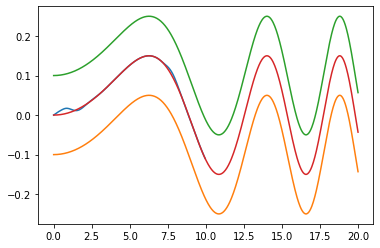

In [40]:
model = mpc_model()
mpc = controller(model,x_ref,y_ref)
simulator = mpc_simulator(model,x_ref,y_ref)
estimator = do_mpc.estimator.StateFeedback(model)

# x0=np.array([[0],[0],[0.001],[(np.pi/4)*(0.03)],[0],[0],[0],[0]])
simulator.x0['xc'] = 0
simulator.x0['yc'] = 0
simulator.x0['v'] = 3
simulator.x0['theta'] = (np.pi/4)*(0.035)
simulator.x0['phi'] = 0
simulator.x0['delta'] = 0
simulator.x0['a_s'] = 0
simulator.x0['w_s'] = 0

x0 = simulator.x0.cat.full()

mpc.x0 = x0
estimator.x0 = x0

mpc.set_initial_guess()

state = []
x = []
y = []
for k in range(N_ref):
    print('\n\n################################################    ' + str(k) + '    #########################################\n\n')
    state.append(x0)
    x.append(x0[0])
    y.append(x0[1])
    u0 = mpc.make_step(x0)
    y_next = simulator.make_step(u0)
    x0 = estimator.make_step(y_next)
    
plt.plot(x,y)
plt.plot(x_ref,y_ref-1e-1)
plt.plot(x_ref,y_ref+1e-1)
plt.plot(x_ref,y_ref)

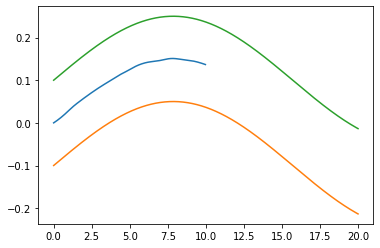

In [156]:
plt.plot(x,y)
plt.plot(x_ref,y_ref-1e-1)
plt.plot(x_ref,y_ref+1e-1)
# plt.plot(x_ref,y_ref)

simulator.x0['xc'] = 0      
simulator.x0['yc'] = 0                  
simulator.x0['v'] = 0.001                       
simulator.x0['theta'] = (np.pi/4)*(0.03)                       
simulator.x0['phi'] = 0                     
simulator.x0['delta'] = 0               
simulator.x0['a_s'] = 0                     
simulator.x0['w_s'] = 0                 


In [ ]:

fig = plt.figure(figsize=(16,9))

ax2 = plt.subplot2grid((4, 2), (0, 0))
ax3 = plt.subplot2grid((4, 2), (1, 0))
ax4 = plt.subplot2grid((4, 2), (2, 0))
ax5 = plt.subplot2grid((4, 2), (3, 0))

ax2.set_ylabel('$$ [J]')
ax3.set_ylabel('$E_{pot}$ [J]')
ax4.set_ylabel('Angle  [rad]')
ax5.set_ylabel('Input force [N]')

# Axis on the right.
for ax in [ax2, ax3, ax4, ax5]:
    ax.yaxis.set_label_position("right")
    ax.yaxis.tick_right()
    if ax != ax5:
        ax.xaxis.set_ticklabels([])

ax5.set_xlabel('time [s]')

mpc_graphics.add_line(var_type='_aux', var_name='E_kin', axis=ax2)
mpc_graphics.add_line(var_type='_aux', var_name='E_pot', axis=ax3)
mpc_graphics.add_line(var_type='_x', var_name='theta', axis=ax4)
mpc_graphics.add_line(var_type='_u', var_name='force', axis=ax5)

ax1.axhline(0,color='black')

bar1 = ax1.plot([],[], '-o', linewidth=5, markersize=10)
bar2 = ax1.plot([],[], '-o', linewidth=5, markersize=10)

ax1.set_xlim(-1.8,1.8)
ax1.set_ylim(-1.2,1.2)
ax1.set_axis_off()

fig.align_ylabels()
fig.tight_layout()

In [169]:
mpc_graphics = do_mpc.graphics.Graphics(mpc.data)
mpc_graphics.plot_predictions()
plt.show()

In [12]:
for i in state:
    print(i[2])

[3.]
[3.00155571]
[3.00623794]
[3.01439298]
[3.02255968]
[3.03108217]
[3.04271434]
[3.05791161]
[3.07630827]
[3.09726842]
[3.11674713]
[3.13143706]
[3.14131699]
[3.14737039]
[3.15076616]
[3.15257657]
[3.15369204]
[3.15809865]
[3.16886242]
[3.18570945]
[3.20733304]
[3.23222675]
[3.25897679]
[3.28635618]
[3.31334615]
[3.33913087]
[3.36308238]
[3.38474189]
[3.4037999]
[3.4200763]
[3.43350089]
[3.44409483]
[3.45195318]
[3.45722882]
[3.46011788]
[3.4608467]
[3.45966048]
[3.45681348]
[3.45256079]
[3.44715165]
[3.44082419]
[3.43380141]
[3.42628847]
[3.41847101]
[3.41051444]
[3.40256394]
[3.39474501]
[3.3871643]
[3.37991058]
[3.37305576]
[3.36665589]
[3.36075225]
[3.35537244]
[3.35053147]
[3.34623297]
[3.34247029]
[3.33922772]
[3.33648165]
[3.33420173]
[3.33235202]
[3.33089216]
[3.32977848]
[3.32896515]
[3.3284053]
[3.32805211]
[3.32785981]
[3.32778466]
[3.32778583]
[3.32782613]
[3.32787265]
[3.32789727]
[3.32787697]
[3.32779402]
[3.32763605]
[3.32739593]
[3.32707151]
[3.32666531]
[3.32618403]